In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import torch

from matplotlib.pyplot import imshow
from pathlib import Path
from sklearn import metrics
from torch.utils.data import DataLoader, Subset
from torchvision import models, transforms
from torchvision.datasets import MNIST
from torchvision.utils import make_grid, save_image
from tqdm.notebook import tqdm, trange

from mnist__conditional_diffusion import DDPM, train_mnist, ContextUnet, sample_ddpms, sample_per_epoch
from metrics import kernel_error, kernel_noise, dist_var, dist_cov, dist_corr, ensemble_block_kernel, Cov_inner_term, Cov_outer_term, Var_inner_term
from utils import show

# make paths which may be missing at first execution
for path in ['results', 'plots']:
    p = Path(path)
    p.mkdir(parents=True, exist_ok=True)

def get_free_gpu_idx():
    """Get the index of the GPU with current lowest memory usage."""
    os.system("nvidia-smi -q -d Memory |grep -A4 GPU|grep Used > tmp")
    memory_available = [int(x.split()[2]) for x in open("tmp", "r").readlines()]
    return np.argmin(memory_available)

gpu_idx = get_free_gpu_idx()

#DEVICE = 'cpu'
#DEVICE = 'mps'
DEVICE = 'cuda:{}'.format(gpu_idx)
# training set size used throughout all experiments
set_size = 60000

print(DEVICE)

In [3]:
# To load 8M generated infimnist instances, do the following:
# 1) run this cell
# 2) get the infimnist execs from https://leon.bottou.org/projects/infimnist
# 3) run "./infimnist lab 70000 8109999 > train-labels-idx1-ubyte"
# and "./infimnist pat 70000 8109999 > train-images-idx3-ubyte"
# 4) move the files into "data/infimnist/MNIST/raw/"
# 5) run this cell again - the shape should now be [8040000, 28, 28]
tf = transforms.Compose([transforms.ToTensor()])
infimnist = MNIST("data/infimnist", train=True, download=True, transform=tf)
# somehow the ddpms generate only trash if we scale to [0,1]
#infimnist.data = torch.div(infimnist.data, 255.0) # scale from [0, 255] to [0, 1]
infimnist.data.shape

torch.Size([8040000, 28, 28])

In [4]:
### DEFINE TEST SET
test_size = 10000
set_id = 33 # we use the first 32 sets as training sets
indices = range(set_size*set_id, set_size*set_id+test_size)
print('Class freq:', torch.bincount(infimnist.targets[indices]))
test_set_per_class = []
for k in range(10):
    mask = infimnist.targets[indices]==k
    test_set_per_class.append(infimnist.data[indices][mask])

Class freq: tensor([1001, 1127,  991, 1032,  980,  863, 1014, 1070,  944,  978])


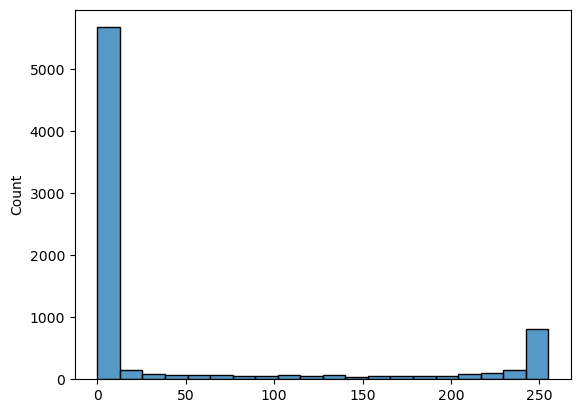

In [4]:
x_real = test_set_per_class[0][0:10]
sns.histplot(make_grid(x_real).flatten().cpu().numpy(), bins=20); #.clamp_(0, 1)

In [5]:
def single_simulation(seed, rng, ens_ids, n_samp, xs_gen, exp_dict, kernel):
    # writes to exp_dict as side-effect
    max_samp = xs_gen.shape[1]
    samp_ids = rng.choice(max_samp, n_samp, replace=False)
    sub_sample = xs_gen[ens_ids,:,:,:,:][:,samp_ids,:,:,:].flatten(2)
    kXX = ensemble_block_kernel(sub_sample, sub_sample, kernel=kernel)

    exp_dict['Seed'].append(seed)
    exp_dict['n_ens'].append(len(ens_ids))
    exp_dict['n_samp'].append(n_samp)
    exp_dict['Var_inner_term'].append(Var_inner_term(kXX, n_ensemble=len(ens_ids)))
    exp_dict['Cov_inner_term'].append(Cov_inner_term(kXX, n_ensemble=len(ens_ids)))
    exp_dict['Cov_outer_term'].append(Cov_outer_term(kXX, n_ensemble=len(ens_ids)))
    exp_dict['dist_var'].append(dist_var(sub_sample))
    exp_dict['dist_cov'].append(dist_cov(sub_sample, sub_sample))

def estimator_simulation(
    xs_gen, seeds=range(5000), n_enss=range(2, 16), n_samps=range(2, 16), rep_ens=True,
    kernel=lambda x, y: metrics.pairwise.rbf_kernel(x, y, gamma=None)
):
    max_ens = xs_gen.shape[0]
    exp_results = {
        'Seed': [],
        'n_ens': [],
        'n_samp': [],
        'Var_inner_term': [],
        'Cov_inner_term': [],
        'Cov_outer_term': [],
        'dist_var': [],
        'dist_cov': []
    }
    if rep_ens:
        for seed in tqdm(seeds, total=len(seeds), desc='Seeds'):
            rng = np.random.default_rng(seed=seed)
            for n_ens in n_enss:
                for n_samp in n_samps:
                    ens_ids = rng.choice(max_ens, n_ens, replace=False)
                    single_simulation(
                        seed, rng, ens_ids, n_samp, xs_gen, exp_results, kernel
                    )
    else:
        # we do not resample the ensemble, so just set one seed
        rng = np.random.default_rng(seed=0)
        for n_ens in tqdm(n_enss, total=len(n_enss), desc='Ensembles'):
            ens_ids = rng.choice(max_ens, n_ens, replace=False)
            for seed in seeds:
                rng = np.random.default_rng(seed=seed)
                for n_samp in n_samps:
                    single_simulation(
                        seed, rng, ens_ids, n_samp, xs_gen, exp_results, kernel
                    )
    return pd.DataFrame(exp_results)

def metrics_per_epoch_class(
    gen_folder,
    epochs,
    classes=range(10),
    kernel=lambda x, y: metrics.pairwise.rbf_kernel(x, y, gamma=None)
):
    load_file = gen_folder + "xs_gen_ep{}.pth"
    metrics_per_epoch = {'Var': [], 'Class': [], 'Epoch': [], 'GE': [], 'Noise': [], 'PK Ent': []}
    for k in tqdm(classes, total=len(classes), desc='Classes'):
        ys = torch.div(test_set_per_class[k].flatten(1), 255.0)
        noise = kernel_noise(ys, kernel=kernel)
        for epoch in tqdm(epochs, total=len(epochs), desc='Epochs', leave=False):
            xs_gen = torch.load(load_file.format(epoch)).clamp_(0, 1)
            ens_ids = range(xs_gen.shape[1])
            var = dist_var(xs_gen[k].flatten(2), kernel=kernel)
            # predictive kernel entropy of the first model
            pred_k_ent = kernel_noise(xs_gen[k, 0].flatten(1), kernel=kernel)
            errors = [kernel_error(xs_gen[k, n].flatten(1), ys, kernel=kernel) for n in ens_ids]
            
            metrics_per_epoch['GE'].append(np.mean(errors))
            metrics_per_epoch['Noise'].append(noise)
            metrics_per_epoch['Var'].append(var)
            metrics_per_epoch['Class'].append(k)
            metrics_per_epoch['Epoch'].append(epoch)
            metrics_per_epoch['PK Ent'].append(pred_k_ent)
    return pd.DataFrame(metrics_per_epoch)

def epoch_correlations(
    gen_folder,
    epochs,
    classes=range(10),
    kernel=lambda x, y: metrics.pairwise.rbf_kernel(x, y, gamma=None)
):
    load_file = gen_folder + "xs_gen_ep{}.pth"
    corr_matrices = np.zeros((len(classes), len(epochs), len(epochs)))
    for i, epoch_i in tqdm(enumerate(epochs), total=len(epochs), desc='Epochs i'):
        xs_gen_i = torch.load(load_file.format(epoch_i)).clamp_(0, 1)
        for j, epoch_j in tqdm(enumerate(epochs), total=len(epochs), desc='Epochs j', leave=False):
            xs_gen_j = torch.load(load_file.format(epoch_j)).clamp_(0, 1)
            for k in classes:
                corr_matrices[k, i, j] = dist_corr(
                    xs_gen_i[k].flatten(2), xs_gen_j[k].flatten(2), kernel=kernel
                )
    return corr_matrices

def epoch_covariances(
    gen_folder,
    epochs,
    classes=range(10),
    kernel=lambda x, y: metrics.pairwise.rbf_kernel(x, y, gamma=None)
):
    load_file = gen_folder + "xs_gen_ep{}.pth"
    cov_matrices = np.zeros((len(classes), len(epochs), len(epochs)))
    for i, epoch_i in tqdm(enumerate(epochs), total=len(epochs), desc='Epochs i'):
        xs_gen_i = torch.load(load_file.format(epoch_i)).clamp_(0, 1)
        for j, epoch_j in tqdm(enumerate(epochs), total=len(epochs), desc='Epochs j', leave=False):
            xs_gen_j = torch.load(load_file.format(epoch_j)).clamp_(0, 1)
            for k in classes:
                cov_matrices[k, i, j] = dist_cov(
                    xs_gen_i[k].flatten(2), xs_gen_j[k].flatten(2), kernel=kernel
                )
    return cov_matrices

def metrics_per_frac(
    load_file,
    fracs=[0.2, 0.4, 0.6, 0.8, 1.0],
    classes=range(10),
    epochs=range(0,51,2),
    kernel=lambda x, y: metrics.pairwise.rbf_kernel(x, y, gamma=None)
):
    metrics_per_epoch = {'GE': [], 'Noise': [], 'Var': [], 'Class': [], 'Epoch': [], 'Zero Frac': [], 'PK Ent': []}
    for k in tqdm(classes, total=len(classes), desc='Classes'):
        ys = torch.div(test_set_per_class[k].flatten(1), 255.0)
        noise = kernel_noise(ys, kernel=kernel)
        for frac in tqdm(fracs, total=len(fracs), desc='Fracs', leave=False):
            for epoch in epochs:
                xs_gen = torch.load(load_file.format(frac, epoch)).clamp_(0, 1)
                ens_ids = range(xs_gen.shape[1])
                var = dist_var(xs_gen[k].flatten(2), kernel=kernel)
                # predictive kernel entropy of the first model
                pred_k_ent = kernel_noise(xs_gen[k, 0].flatten(1), kernel=kernel)
                errors = [kernel_error(xs_gen[k, n].flatten(1), ys, kernel=kernel) for n in ens_ids]
                metrics_per_epoch['GE'].append(np.mean(errors))
                metrics_per_epoch['Noise'].append(noise)
                metrics_per_epoch['Var'].append(var)
                metrics_per_epoch['Class'].append(k)
                metrics_per_epoch['Epoch'].append(epoch)
                metrics_per_epoch['Zero Frac'].append(frac)
                metrics_per_epoch['PK Ent'].append(pred_k_ent)
    return pd.DataFrame(metrics_per_epoch)

In [ ]:
# # training 20 ddpms up to 100 epochs (~ 20h on rtx5000; did that in slurm)
# save_dir = "models/infimnist/ddpm/set_id_{}/"
# n_epoch = 100
# set_size = 60000
# n_ddpms = 20
# for set_id in trange(0, n_ddpms, desc='DDPMs'):
#     set_dir = save_dir.format(set_id)

#     p = Path(set_dir)
#     p.mkdir(parents=True, exist_ok=True)

#     indices = range(set_size*set_id, set_size*(set_id+1))
#     dataset = Subset(infimnist, indices)
#     train_mnist(
#         dataset, save_dir=set_dir, n_epoch=n_epoch, save_model=True,
#         device=device, ws_test=[], leave=False
#     )

In [6]:
# # train 12 ddpms up to 20 epochs (~ 4 hours on RTX5000; did that in slurm)
# save_dir = "models/infimnist/ddpm/set_id_{}/"
# n_epoch = 20
# ddpm_ids = range(20, 32)
# for set_id in tqdm(ddpm_ids, desc='DDPMs'):
#     set_dir = save_dir.format(set_id)

#     p = Path(set_dir)
#     p.mkdir(parents=True, exist_ok=True)

#     indices = range(set_size*set_id, set_size*(set_id+1))
#     dataset = Subset(infimnist, indices)
#     ddpm = train_mnist(
#         dataset, save_dir=set_dir, n_epoch=n_epoch, save_model=True,
#         device=DEVICE, ws_test=[], leave=False,
#     )

In [8]:
state_dict_files = ['models/infimnist/ddpm/set_id_{}/model_{}.pth'.format(i, 19) for i in [19, 31]]
xs_gen = sample_ddpms(state_dict_files, 50, DEVICE, leave=False)

Models:   0%|          | 0/2 [00:00<?, ?it/s]

Diffusion iterations:   0%|          | 0/400 [00:00<?, ?it/s]

Diffusion iterations:   0%|          | 0/400 [00:00<?, ?it/s]

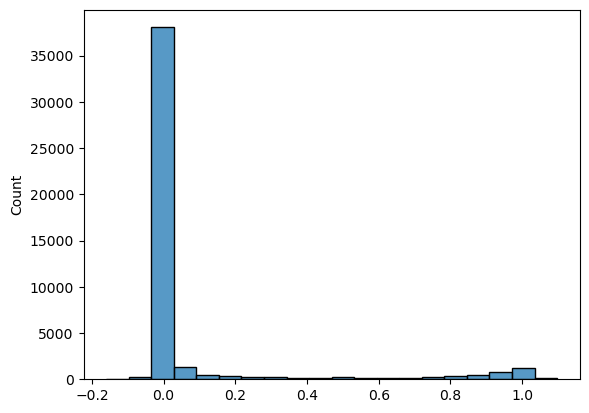

In [9]:
x_real = xs_gen[0][0:5,:,:,:,:][:,0:5,:,:,:].flatten(0,1)
sns.histplot(make_grid(x_real).flatten().cpu().numpy(), bins=20); #.clamp_(0, 1)

In [45]:
# GENERATE SAMPLES from epoch 21 models (n_sample=1000 takes ~2.5 hours on RTX5000)
ddpm_ids = range(32)
n_epoch = 21
state_dict_files = ['models/infimnist/ddpm/setid{}_frac1.0/model_ep{}.pth'.format(i, n_epoch-1) for i in ddpm_ids]
xs_gen = sample_ddpms(state_dict_files, n_sample=1000, device=DEVICE)
torch.save(xs_gen, 'models/infimnist/ddpm/generated_frac1.0/xs_gen_ep20_n32_m100.pth')

Models:   0%|          | 0/32 [00:00<?, ?it/s]

Diffusion iterations:   0%|          | 0/400 [00:00<?, ?it/s]

Diffusion iterations:   0%|          | 0/400 [00:00<?, ?it/s]

Diffusion iterations:   0%|          | 0/400 [00:00<?, ?it/s]

Diffusion iterations:   0%|          | 0/400 [00:00<?, ?it/s]

Diffusion iterations:   0%|          | 0/400 [00:00<?, ?it/s]

Diffusion iterations:   0%|          | 0/400 [00:00<?, ?it/s]

Diffusion iterations:   0%|          | 0/400 [00:00<?, ?it/s]

Diffusion iterations:   0%|          | 0/400 [00:00<?, ?it/s]

Diffusion iterations:   0%|          | 0/400 [00:00<?, ?it/s]

Diffusion iterations:   0%|          | 0/400 [00:00<?, ?it/s]

Diffusion iterations:   0%|          | 0/400 [00:00<?, ?it/s]

Diffusion iterations:   0%|          | 0/400 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Diffusion iterations:   0%|          | 0/400 [00:00<?, ?it/s]

Diffusion iterations:   0%|          | 0/400 [00:00<?, ?it/s]

Diffusion iterations:   0%|          | 0/400 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



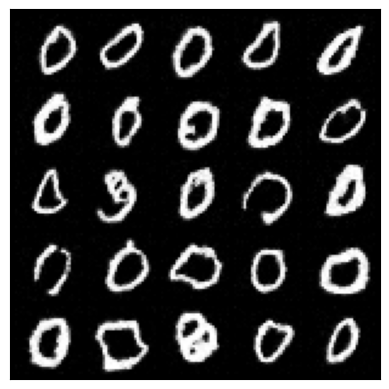

In [46]:
# make sure the generated images are decent
xs_gen = torch.load('models/infimnist/ddpm/generated_frac1.0/xs_gen_ep20_n32_m100.pth').clamp_(0,1)
grid = make_grid(xs_gen[0][0:5,:,:,:,:][:,0:5,:,:,:].flatten(0,1), nrow=5)
show(grid)

In [47]:
# ~25 minutes on RTX5000
xs_gen = torch.load('models/infimnist/ddpm/generated_frac1.0/xs_gen_ep20_n32_m100.pth').clamp_(0,1)
seeds = range(1000)
for class_i in range(1):
    exp_results = estimator_simulation(xs_gen[class_i], seeds=seeds)
    exp_results.to_csv('results/estimator_simulation_class{}_{}reps_ep20_n32_m100.csv'.format(class_i, len(list(seeds))))
# for class_i in range(1):
#     exp_results = estimator_simulation(xs_gen[class_i], reps=1000, rep_ens=False)
#     exp_results.to_csv('results/estimator_simulation_class{}_{}reps_norepens.csv'.format(class_i, reps))

Seeds:   0%|          | 0/1000 [00:00<?, ?it/s]

In [ ]:
# # GENERATE SAMPLES from 1 epoch model
# ddpm_ids = range(32)
# n_epoch = 1
# state_dict_files = ['models/infimnist/ddpm/set_id_{}/model_{}.pth'.format(i, n_epoch-1) for i in ddpm_ids]
# xs_gen = sample_ddpms(state_dict_files, n_sample=320, device=DEVICE)
# torch.save(xs_gen, 'models/infimnist/ddpm/generated/xs_gen_32x320_ep{}.pth'.format(n_epoch))

In [39]:
# n_epoch = 1
# xs_gen = torch.load('models/infimnist/ddpm/generated/xs_gen_32x320_ep{}.pth'.format(n_epoch))
# seeds = range(1000)
# for class_i in range(1):
#     exp_results = estimator_simulation(xs_gen[class_i], seeds=seeds)
#     exp_results.to_csv('results/estimator_simulation_class{}_{}reps_ep{}.csv'.format(class_i, len(list(seeds)), n_epoch))

Seeds:   0%|          | 0/5000 [00:00<?, ?it/s]

In [5]:
class_i = 0 # similar for all classes
reps = 1000
exp_results = pd.read_csv('results/estimator_simulation_class{}_{}reps_ep20_n32_m100.csv'.format(class_i, reps), index_col=0)
exp_results

,Seed,n_ens,n_samp,Var_inner_term,Cov_inner_term,Cov_outer_term,dist_var,dist_cov
0,0,2,2,0.910055,0.955027,0.908615,0.001440,0.046412
1,0,2,3,0.894381,0.929587,0.890049,0.004332,0.039538
2,0,2,4,0.876569,0.907427,0.887122,-0.010553,0.020305
3,0,2,5,0.896041,0.916832,0.891295,0.004746,0.025537
4,0,2,6,0.887107,0.905922,0.889212,-0.002105,0.016711
...,...,...,...,...,...,...,...,...
195995,999,15,11,0.878006,0.889096,0.876465,0.001541,0.012631
195996,999,15,12,0.878804,0.888903,0.879510,-0.000707,0.009393
195997,999,15,13,0.884153,0.893065,0.884180,-0.000026,0.008885
195998,999,15,14,0.878554,0.887229,0.878890,-0.000336,0.008338


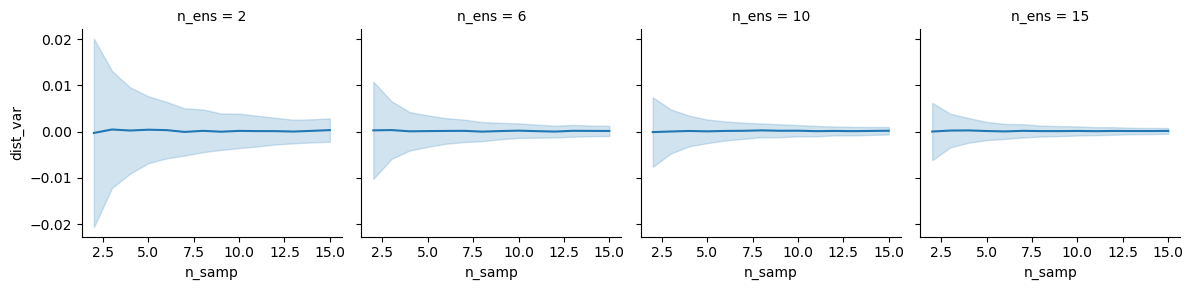

In [50]:
sub_results = exp_results[exp_results['n_ens'].isin([2, 6, 10, 15])]
g = sns.FacetGrid(data=sub_results, col='n_ens')
g.map(sns.lineplot, 'n_samp', 'dist_var', errorbar='sd');

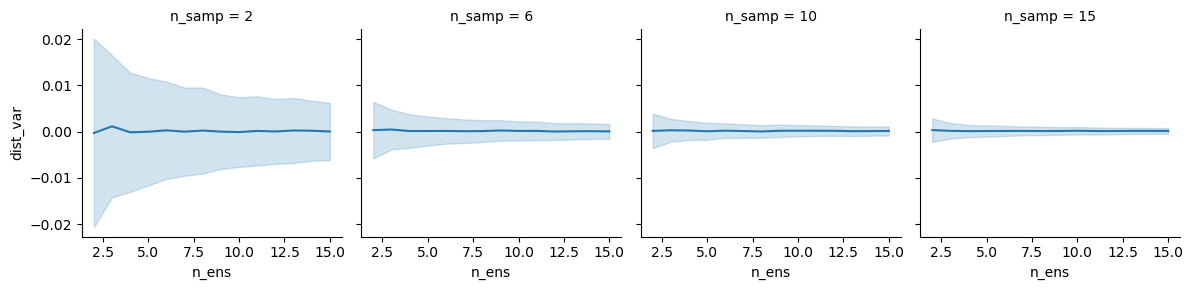

In [51]:
sub_results = exp_results[exp_results['n_samp'].isin([2, 6, 10, 15])]
g = sns.FacetGrid(data=sub_results, col='n_samp')
g.map(sns.lineplot, 'n_ens', 'dist_var', errorbar='sd');

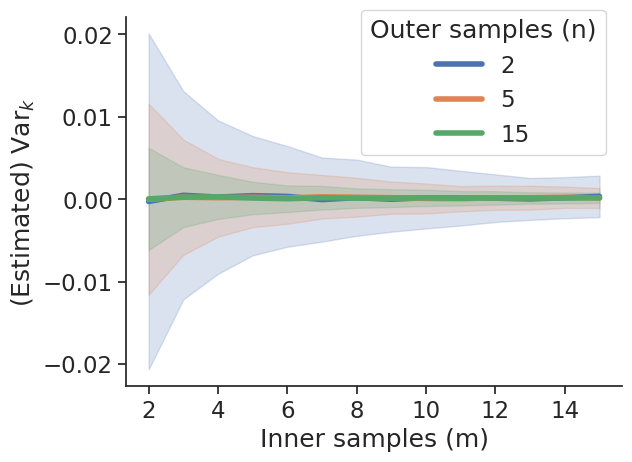

In [6]:
### Figure 2 Right
sub_results = exp_results[exp_results['n_ens'].isin([2, 5, 15])]
sns.set(font_scale=1.5)
sns.set_style('ticks')
line_size = 4
plot = sns.lineplot(data=sub_results, x='n_samp', y='dist_var', hue='n_ens', errorbar='sd', palette=sns.color_palette()[0:3], linewidth=line_size)
plot.axes.set_xticks([2, 4, 6, 8, 10, 12, 14])
plot.set(ylabel='(Estimated) Var$_k$', xlabel='Inner samples (m)')
leg = plot.legend(title='Outer samples (n)')
for line in leg.get_lines():
    line.set_linewidth(4)
sns.move_legend(plot, "upper left", bbox_to_anchor=(0.45, 1.05))
sns.despine()
plot.figure.savefig('plots/sim_var.svg', bbox_inches='tight')
plot.figure.show();

<Axes: xlabel='n_ens', ylabel='n_samp'>

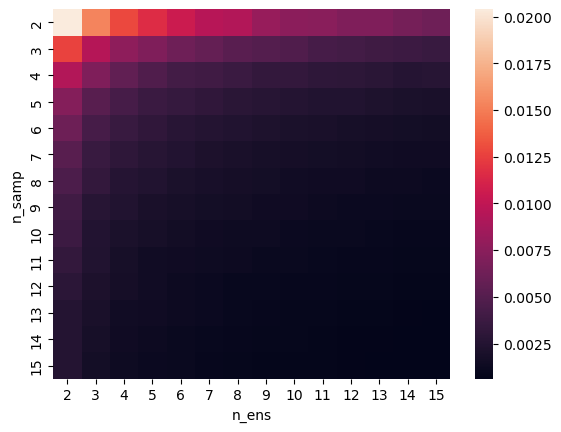

In [53]:
# RMSE ~ STD, since estimator is unbiased
target = 'dist_var'
sns.heatmap(exp_results.groupby(['n_samp', 'n_ens'])[target].std().reset_index().pivot(index='n_samp', columns='n_ens', values=target))

In [9]:
# # ~60 hours on rtx5000 (also did that in slurm)
# torch.manual_seed(0)
# epochs = range(150)
# ddpm_ids = range(20)
# n_sample = 200 # 20 per class
# sample_per_epoch(epochs, ddpm_ids, n_sample=n_sample, device=DEVICE, save_folder=GEN_FOLDER)

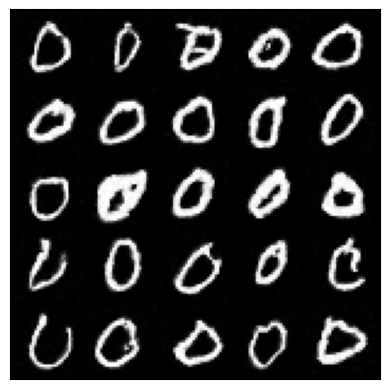

In [5]:
# make sure the generated images are decent
xs_gen = torch.load('models/infimnist/ddpm/generated_frac1.0/xs_gen_ep50.pth').clamp_(0, 1)
grid = make_grid(xs_gen[0][0:5,:,:,:,:][:,0:5,:,:,:].flatten(0,1), nrow=5)
show(grid)

In [ ]:
####################################
### GROUND TRUTH 100% TRAIN DATA ###
####################################

In [ ]:
# RUN THIS CELL FOR THE FOLLOWING PLOTS (<5 minutes)
gen_folder = 'models/infimnist/ddpm/generated_frac1.0/'
epochs = range(0, 41, 2)
ddpm_ids = range(20)
exp_results = metrics_per_epoch_class(gen_folder, epochs)
torch.save(exp_results, 'results/frac1.0_metrics_per_class.pth')

In [10]:
exp_results = torch.load('results/frac1.0_metrics_per_class.pth')
exp_results = exp_results[exp_results['Epoch']<=40]
exp_results['sMMD'] = exp_results['GE'] - exp_results['Noise']
exp_results['Bias'] = exp_results['sMMD'] - exp_results['Var']

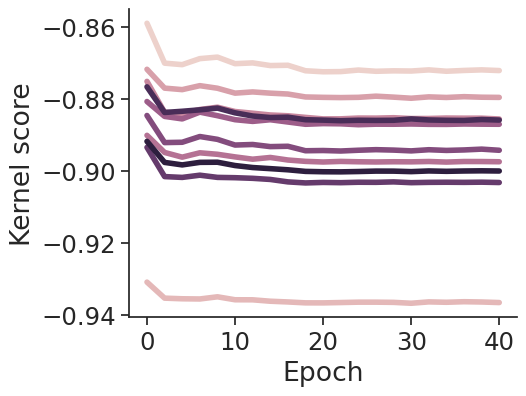

In [29]:
### Figure 8 Left
sns.set(font_scale=1.6)
sns.set_style('ticks')
plt.figure(figsize=(5, 4))
line_size = 4
plot = sns.lineplot(data=exp_results, y='GE', x='Epoch', hue='Class', linewidth=line_size, legend=False)
plot.set(ylabel='Kernel score', xlabel='Epoch')
sns.despine()
plot.figure.savefig('plots/ge_per_epoch_frac1.0.svg', bbox_inches='tight')
plot.figure.show();

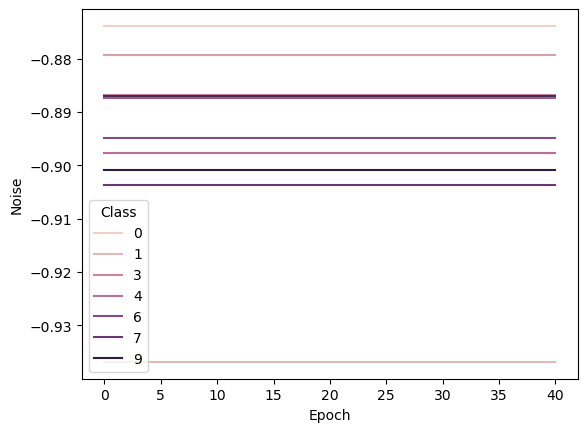

In [21]:
sns.lineplot(data=exp_results, y='Noise', x='Epoch', hue='Class');

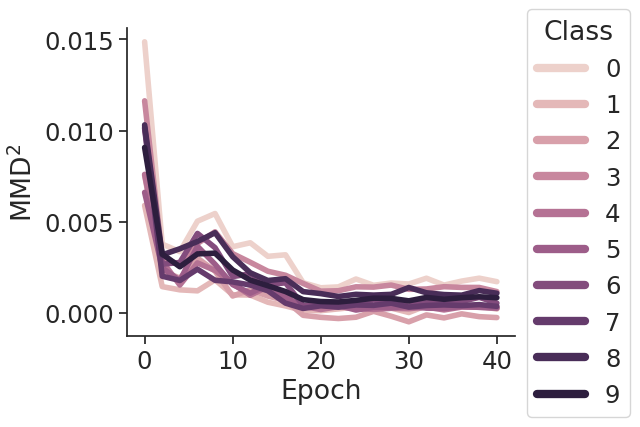

In [26]:
### Figure 8 Mid
sns.set(font_scale=1.6)
sns.set_style('ticks')
plt.figure(figsize=(5, 4))
line_size = 4
plot = sns.lineplot(
    data=exp_results,
    y='sMMD',
    x='Epoch',
    hue='Class',
    linewidth=line_size,
    legend='full',
)
plot.set(ylabel='MMD$^2$', xlabel='Epoch')
sns.despine()
leg = plt.legend(title='Class')
for line in leg.get_lines():
    line.set_linewidth(6)
sns.move_legend(plot, "upper left", bbox_to_anchor=(1, 1.1))
plot.figure.savefig('plots/mmd_per_epoch_frac1.0.svg', bbox_inches='tight')
plot.figure.show();

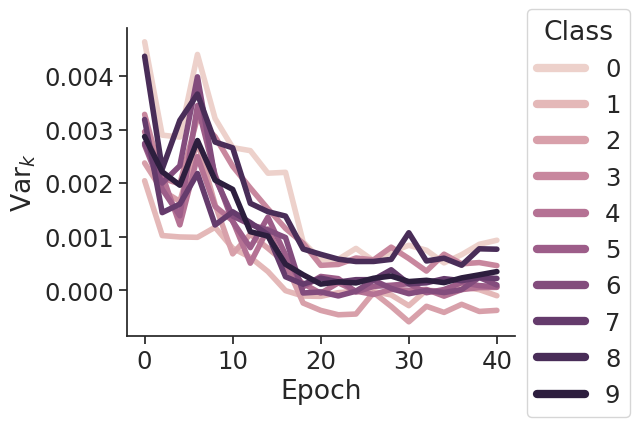

In [24]:
### Figure 3 Left
sns.set(font_scale=1.6)
sns.set_style('ticks')
plt.figure(figsize=(5, 4))
line_size = 4
plot = sns.lineplot(data=exp_results, y='Var', x='Epoch', hue='Class', linewidth=line_size, legend='full')
sns.despine()
plot.set(ylabel='Var$_k$', xlabel='Epoch')
leg = plt.legend(title='Class')
for line in leg.get_lines():
    line.set_linewidth(6)
sns.move_legend(plot, "upper left", bbox_to_anchor=(1, 1.1))
plot.figure.savefig('plots/var_per_epoch_frac1.0.svg', bbox_inches='tight')
plot.figure.show();

In [13]:
# avg variance after 20 epochs
exp_results[exp_results['Epoch']>=20]['Var'].mean()

0.00020319894306967932

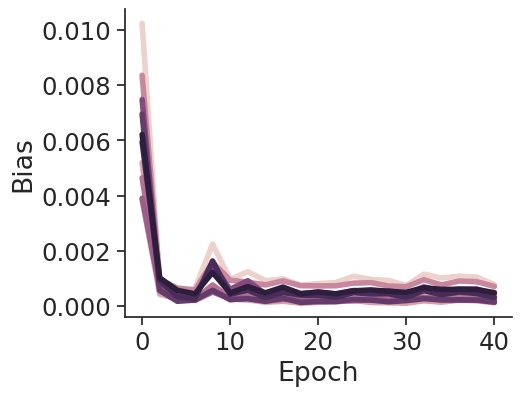

In [6]:
### Figure 3 Mid
sns.set(font_scale=1.6)
sns.set_style('ticks')
plt.figure(figsize=(5, 4))
line_size = 4
plot = sns.lineplot(data=exp_results, y='Bias', x='Epoch', hue='Class', linewidth=line_size, legend=False)
sns.despine()
plot.set(ylabel='Bias', xlabel='Epoch')
plot.figure.savefig('plots/bias_per_epoch_frac1.0.svg', bbox_inches='tight')
plot.figure.show();

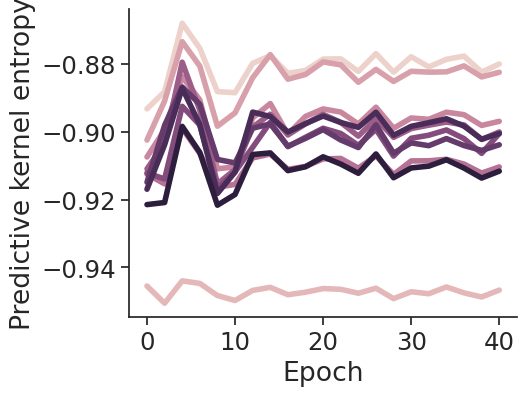

In [31]:
### Figure 8 Right
sns.set(font_scale=1.6)
sns.set_style('ticks')
plt.figure(figsize=(5, 4))
line_size = 4
plot = sns.lineplot(data=exp_results, y='PK Ent', x='Epoch', hue='Class', linewidth=line_size, legend=False)
sns.despine()
plot.set(ylabel='Predictive kernel entropy', xlabel='Epoch')
plot.figure.savefig('plots/pkent_per_epoch_frac1.0.svg', bbox_inches='tight')
plot.figure.show();

In [12]:
exp_results.corr(method='pearson')

,Var,Class,Epoch,GE,Noise,sMMD,Bias
Var,1.000000,1.961220e-02,-7.095476e-01,0.313214,2.202956e-01,0.855296,0.541320
Class,0.019612,1.000000e+00,3.552112e-16,-0.032447,-3.092124e-02,-0.020467,-0.049817
Epoch,-0.709548,3.552112e-16,1.000000e+00,-0.066821,-2.631183e-16,-0.577832,-0.336966
GE,0.313214,-3.244740e-02,-6.682132e-02,1.000000,9.935066e-01,0.289730,0.204989
Noise,0.220296,-3.092124e-02,-2.631183e-16,0.993507,1.000000e+00,0.178954,0.103892
sMMD,0.855296,-2.046713e-02,-5.778320e-01,0.289730,1.789537e-01,1.000000,0.898650
Bias,0.541320,-4.981728e-02,-3.369659e-01,0.204989,1.038924e-01,0.898650,1.000000


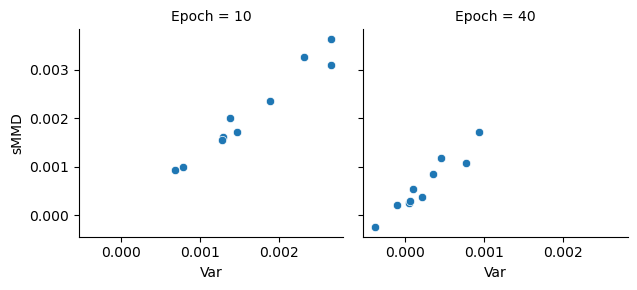

In [29]:
g = sns.FacetGrid(data=exp_results[exp_results['Epoch'].isin(range(10, 41, 30))], col="Epoch", col_wrap=5)
plot = g.map(sns.scatterplot, 'Var', 'sMMD')
plot.figure.savefig('plots/mmd_vs_var_per_epoch_frac1.0.svg', bbox_inches='tight')
plot.figure.show();

/home/sgruber/miniconda3/envs/TTS/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


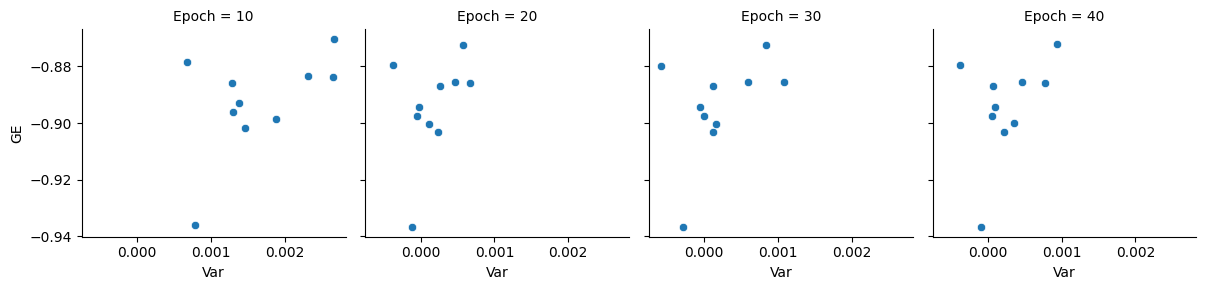

In [3]:
g = sns.FacetGrid(data=exp_results[exp_results['Epoch'].isin(range(10, 41, 10))], col="Epoch", col_wrap=5)
plot = g.map(sns.scatterplot, 'Var', 'GE')
#plot.figure.savefig('plots/mmd_vs_var_per_epoch_frac1.0.svg', bbox_inches='tight')
plot.figure.show();

/home/sgruber/miniconda3/envs/TTS/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


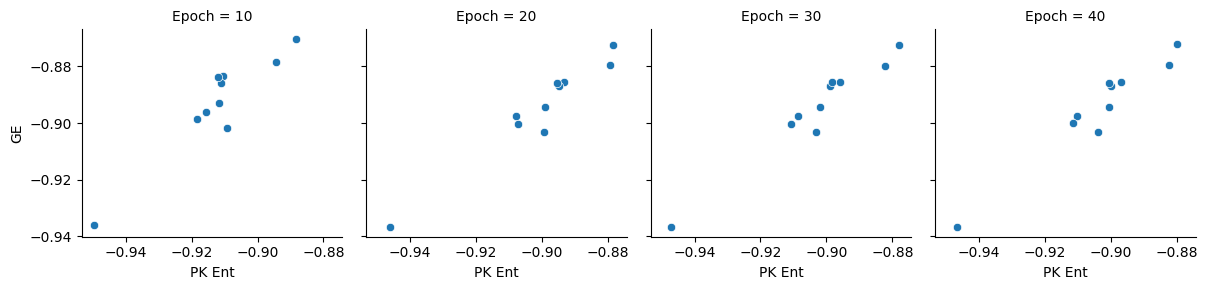

In [15]:
g = sns.FacetGrid(data=exp_results[exp_results['Epoch'].isin(range(10, 41, 10))], col="Epoch", col_wrap=5)
plot = g.map(sns.scatterplot, 'PK Ent', 'GE')
#plot.figure.savefig('plots/mmd_vs_var_per_epoch_frac1.0.svg', bbox_inches='tight')
plot.figure.show();

/home/sgruber/miniconda3/envs/TTS/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


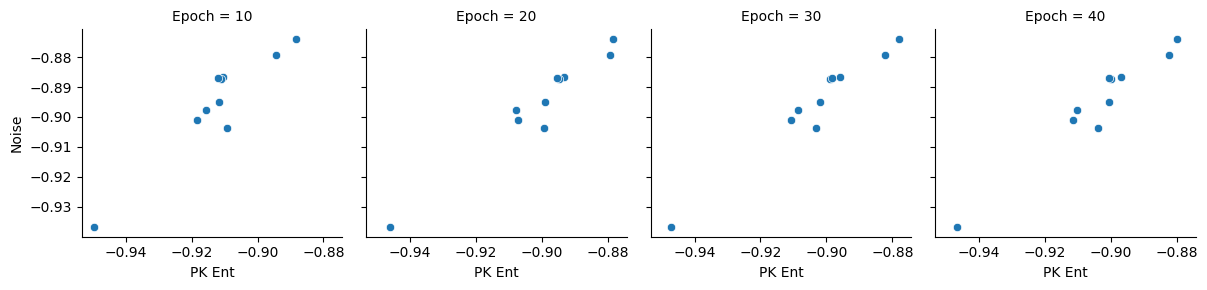

In [17]:
g = sns.FacetGrid(data=exp_results[exp_results['Epoch'].isin(range(10, 41, 10))], col="Epoch", col_wrap=5)
plot = g.map(sns.scatterplot, 'PK Ent', 'Noise')
#plot.figure.savefig('plots/mmd_vs_var_per_epoch_frac1.0.svg', bbox_inches='tight')
plot.figure.show();

/home/sgruber/miniconda3/envs/TTS/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


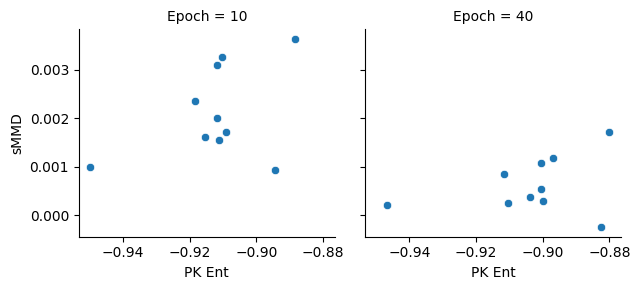

In [16]:
g = sns.FacetGrid(data=exp_results[exp_results['Epoch'].isin(range(10, 41, 30))], col="Epoch", col_wrap=5)
plot = g.map(sns.scatterplot, 'PK Ent', 'sMMD')
#plot.figure.savefig('plots/mmd_vs_var_per_epoch_frac1.0.svg', bbox_inches='tight')
plot.figure.show();

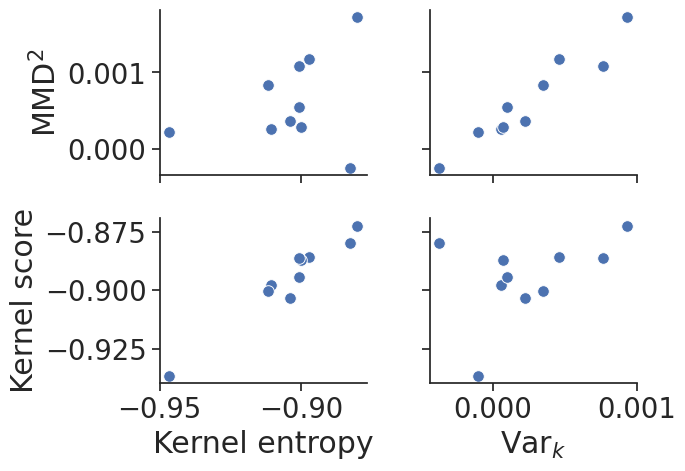

In [9]:
### Figure 4 Left
sub_results = exp_results[exp_results['Epoch'].isin([40])]
x_vars = ['PK Ent', 'Var']
y_vars = ['sMMD', 'GE']
sns.set(font_scale=1.8)
sns.set_style('ticks')
plot = sns.PairGrid(sub_results, x_vars=x_vars, y_vars=y_vars, aspect=1.2)
plot.map(sns.scatterplot, s=70)
plot.add_legend()
plot.axes[0,0].yaxis.set_label_text('MMD$^2$', visible=True)
plot.axes[1,0].yaxis.set_label_text('Kernel score', visible=True)
plot.axes[1,0].xaxis.set_label_text('Kernel entropy', visible=True)
plot.axes[1,1].xaxis.set_label_text('Var$_k$', visible=True)
plot.figure.savefig('plots/scatter_pke_var_vs_smmd_ge.svg', bbox_inches='tight')
plot.figure.show();

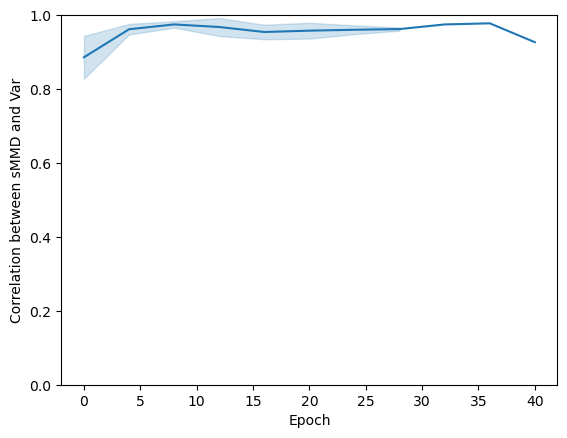

In [25]:
# Pearson correlation between sMMD and variance throughout epochs
exp_results['Corr'] = exp_results.groupby('Epoch')[['Var','sMMD']].corr(method='pearson').reset_index()['sMMD'][range(0,41,2)]
plot = sns.lineplot(data=exp_results, y='Corr', x='Epoch')
plot.set(ylabel='Correlation between sMMD and Var', ylim=(0,1))
plot.figure.savefig('plots/corr_default.svg', bbox_inches='tight')
plot.figure.show();

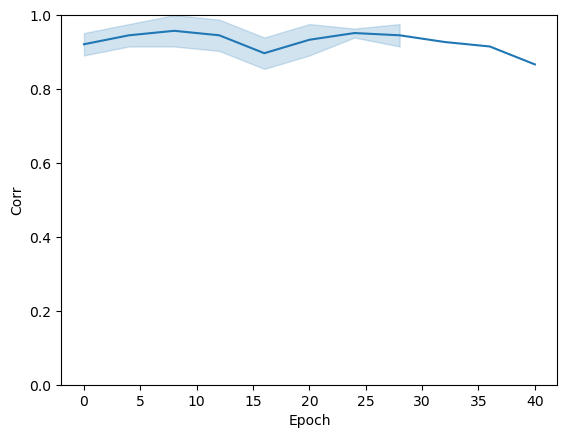

In [26]:
# Spearman correlation
exp_results['Corr'] = exp_results.groupby('Epoch')[['Var','sMMD']].corr(method='spearman').reset_index()['sMMD'][range(0,41,2)]
sns.lineplot(data=exp_results, y='Corr', x='Epoch').set(ylim=(0,1));

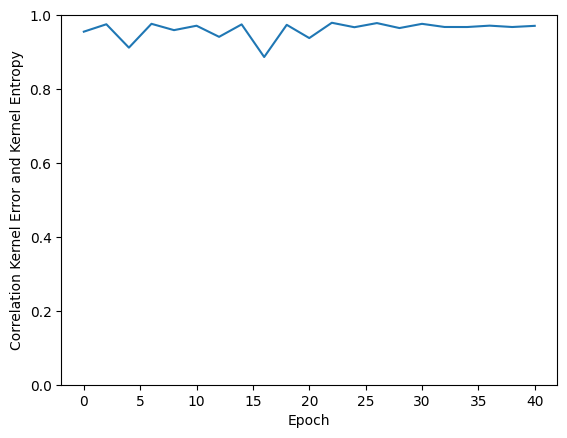

In [23]:
# Pearson correlation between sMMD and variance throughout epochs
exp_results['Corr GE vs PKE'] = exp_results.groupby('Epoch')[['PK Ent','GE']].corr(method='pearson').reset_index()['GE'][range(0,41,2)]
plot = sns.lineplot(data=exp_results, y='Corr GE vs PKE', x='Epoch')
plot.set(ylabel='Correlation Kernel Error and Kernel Entropy', ylim=(0,1))
plot.figure.savefig('plots/corr_ge_vs_pke_default.svg', bbox_inches='tight')
plot.figure.show();

In [30]:
# ~ 6 minutes (RTX 5000)
gen_folder = 'models/infimnist/ddpm/generated_frac1.0/'
corr_matrices = epoch_correlations(gen_folder, range(0,41,2))
torch.save(corr_matrices, 'results/frac1.0_corr_matrices.pth')

Epochs i:   0%|          | 0/21 [00:00<?, ?it/s]

Epochs j:   0%|          | 0/21 [00:00<?, ?it/s]

Epochs j:   0%|          | 0/21 [00:00<?, ?it/s]

Epochs j:   0%|          | 0/21 [00:00<?, ?it/s]

Epochs j:   0%|          | 0/21 [00:00<?, ?it/s]

Epochs j:   0%|          | 0/21 [00:00<?, ?it/s]

Epochs j:   0%|          | 0/21 [00:00<?, ?it/s]

Epochs j:   0%|          | 0/21 [00:00<?, ?it/s]

Epochs j:   0%|          | 0/21 [00:00<?, ?it/s]

Epochs j:   0%|          | 0/21 [00:00<?, ?it/s]

Epochs j:   0%|          | 0/21 [00:00<?, ?it/s]

Epochs j:   0%|          | 0/21 [00:00<?, ?it/s]

Epochs j:   0%|          | 0/21 [00:00<?, ?it/s]

Epochs j:   0%|          | 0/21 [00:00<?, ?it/s]

Epochs j:   0%|          | 0/21 [00:00<?, ?it/s]

Epochs j:   0%|          | 0/21 [00:00<?, ?it/s]

Epochs j:   0%|          | 0/21 [00:00<?, ?it/s]

Epochs j:   0%|          | 0/21 [00:00<?, ?it/s]

Epochs j:   0%|          | 0/21 [00:00<?, ?it/s]

Epochs j:   0%|          | 0/21 [00:00<?, ?it/s]

Epochs j:   0%|          | 0/21 [00:00<?, ?it/s]

Epochs j:   0%|          | 0/21 [00:00<?, ?it/s]

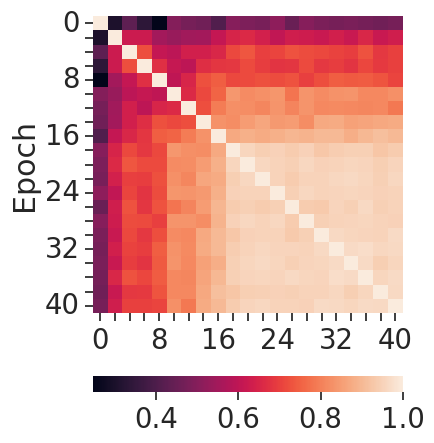

In [5]:
corr_matrices = torch.load('results/frac1.0_corr_matrices.pth')
class_i = 0
plt.figure(figsize=(4, 5.5))
sns.set(font_scale=1.8)
sns.set_style('ticks')
ticks = [i if i%8==0 else None for i in range(0, 41, 2)]
plot = sns.heatmap(
    corr_matrices[class_i], vmin=None, vmax=1, xticklabels=ticks, yticklabels=ticks,
    cbar_kws = dict(use_gridspec=False, location="bottom", ticks=[0.4, 0.6, 0.8, 1.0])
)
plot.set_yticklabels(plot.get_yticklabels(), rotation = 0)
plot.set_ylabel('Epoch')
#plot.set_xlabel('Epoch')
plot.figure.savefig('plots/corr_matrix_{}_default.svg'.format(class_i), bbox_inches='tight')
plot.figure.show();

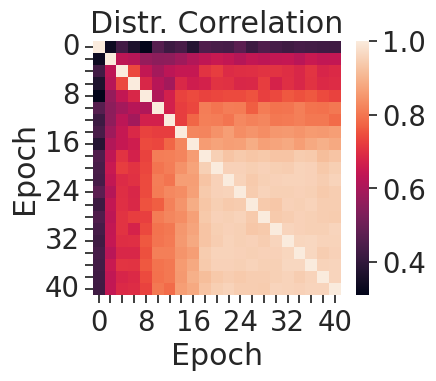

In [22]:
### Figure 3 Right
corr_matrices = torch.load('results/frac1.0_corr_matrices.pth')
plt.figure(figsize=(4, 3.3))
sns.set(font_scale=1.8)
sns.set_style('ticks')
ticks = [i if i%8==0 else None for i in range(0, 41, 2)]
plot = sns.heatmap(
    corr_matrices.mean(axis=0), vmin=None, vmax=1, xticklabels=ticks, yticklabels=ticks,
    cbar_kws = dict(use_gridspec=False, location="right", ticks=[0.4, 0.6, 0.8, 1.0])
)
plot.set_yticklabels(plot.get_yticklabels(), rotation = 0)
plot.set_ylabel('Epoch')
plot.set_xlabel('Epoch')
plot.set_title('Distr. Correlation')
plot.figure.savefig('plots/corr_matrix_avg_default.svg', bbox_inches='tight')
plot.figure.show();

In [6]:
# ~ 1 minutes (RTX 5000)
gen_folder = 'models/infimnist/ddpm/generated_frac1.0/'
cov_matrices = epoch_covariances(gen_folder, range(0,41,2))
torch.save(cov_matrices, 'results/frac1.0_cov_matrices.pth')

Epochs i:   0%|          | 0/21 [00:00<?, ?it/s]

Epochs j:   0%|          | 0/21 [00:00<?, ?it/s]

Epochs j:   0%|          | 0/21 [00:00<?, ?it/s]

Epochs j:   0%|          | 0/21 [00:00<?, ?it/s]

Epochs j:   0%|          | 0/21 [00:00<?, ?it/s]

Epochs j:   0%|          | 0/21 [00:00<?, ?it/s]

Epochs j:   0%|          | 0/21 [00:00<?, ?it/s]

Epochs j:   0%|          | 0/21 [00:00<?, ?it/s]

Epochs j:   0%|          | 0/21 [00:00<?, ?it/s]

Epochs j:   0%|          | 0/21 [00:00<?, ?it/s]

Epochs j:   0%|          | 0/21 [00:00<?, ?it/s]

Epochs j:   0%|          | 0/21 [00:00<?, ?it/s]

Epochs j:   0%|          | 0/21 [00:00<?, ?it/s]

Epochs j:   0%|          | 0/21 [00:00<?, ?it/s]

Epochs j:   0%|          | 0/21 [00:00<?, ?it/s]

Epochs j:   0%|          | 0/21 [00:00<?, ?it/s]

Epochs j:   0%|          | 0/21 [00:00<?, ?it/s]

Epochs j:   0%|          | 0/21 [00:00<?, ?it/s]

Epochs j:   0%|          | 0/21 [00:00<?, ?it/s]

Epochs j:   0%|          | 0/21 [00:00<?, ?it/s]

Epochs j:   0%|          | 0/21 [00:00<?, ?it/s]

Epochs j:   0%|          | 0/21 [00:00<?, ?it/s]

In [19]:
### Equation (17)
cov_matrices = torch.load('results/frac1.0_cov_matrices.pth')
# avg cov after 20 epochs
avg_cov_post_init = cov_matrices.mean(axis=0)[10:, 10:]
off_diag_sum = np.sum(avg_cov_post_init) - np.sum(np.diag(avg_cov_post_init))
total_avg_cov_post_init = off_diag_sum / (avg_cov_post_init.shape[0]**2 - avg_cov_post_init.shape[0])
print(total_avg_cov_post_init)
print(np.mean(np.diag(avg_cov_post_init)))
#print(np.round(cov_matrices.mean(axis=0), 4))
print(np.round(avg_cov_post_init, 4)*1000)

0.004891158347107006
0.005147304562518475
[[5.1 4.9 4.9 4.9 4.9 4.9 4.8 4.9 4.9 4.8 4.9]
 [4.9 5.1 4.9 4.8 4.9 4.9 4.9 4.9 4.9 4.9 4.9]
 [4.9 4.9 5.1 4.8 4.9 4.9 4.8 4.9 4.9 4.8 4.9]
 [4.9 4.8 4.8 5.1 4.9 4.8 4.9 4.9 4.9 4.9 4.9]
 [4.9 4.9 4.9 4.9 5.2 4.9 4.9 4.9 4.9 4.9 4.9]
 [4.9 4.9 4.9 4.8 4.9 5.2 4.9 4.9 4.9 4.9 5. ]
 [4.8 4.9 4.8 4.9 4.9 4.9 5.1 4.9 4.9 4.9 4.9]
 [4.9 4.9 4.9 4.9 4.9 4.9 4.9 5.1 4.9 4.9 4.9]
 [4.9 4.9 4.9 4.9 4.9 4.9 4.9 4.9 5.1 4.9 5. ]
 [4.8 4.9 4.8 4.9 4.9 4.9 4.9 4.9 4.9 5.2 5. ]
 [4.9 4.9 4.9 4.9 4.9 5.  4.9 4.9 5.  5.  5.2]]


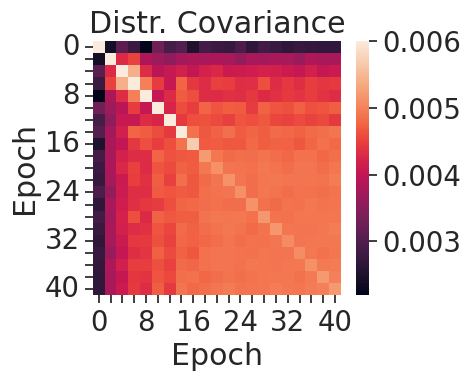

In [9]:
cov_matrices = torch.load('results/frac1.0_cov_matrices.pth')
plt.figure(figsize=(4, 3.3))
sns.set(font_scale=1.8)
sns.set_style('ticks')
ticks = [i if i%8==0 else None for i in range(0, 41, 2)]
plot = sns.heatmap(
    cov_matrices.mean(axis=0), vmin=None, vmax=0.006, xticklabels=ticks, yticklabels=ticks,
    cbar_kws = dict(use_gridspec=False, location="right")#, ticks=[0.4, 0.6, 0.8, 1.0])
)
plot.set_yticklabels(plot.get_yticklabels(), rotation = 0)
plot.set_ylabel('Epoch')
plot.set_xlabel('Epoch')
plot.set_title('Distr. Covariance')
plot.figure.savefig('plots/cov_matrix_avg_default.svg', bbox_inches='tight')
plot.figure.show();

In [61]:
##########################################
### GROUND TRUTH X% class 0 TRAIN DATA ###
##########################################
frac = 0.01

In [6]:
# RUN THIS CELL FOR THE FOLLOWING PLOTS (~1 minutes)
gen_folder = 'models/infimnist/ddpm/generated_frac{}/'.format(frac)
epochs = range(0, 51, 2)
ddpm_ids = range(20)
exp_results = metrics_per_epoch_class(gen_folder, epochs)
torch.save(exp_results, 'results/frac{}_metrics_per_class.pth'.format(frac))

Classes:   0%|          | 0/10 [00:00<?, ?it/s]

Epochs:   0%|          | 0/26 [00:00<?, ?it/s]

Epochs:   0%|          | 0/26 [00:00<?, ?it/s]

Epochs:   0%|          | 0/26 [00:00<?, ?it/s]

Epochs:   0%|          | 0/26 [00:00<?, ?it/s]

Epochs:   0%|          | 0/26 [00:00<?, ?it/s]

Epochs:   0%|          | 0/26 [00:00<?, ?it/s]

Epochs:   0%|          | 0/26 [00:00<?, ?it/s]

Epochs:   0%|          | 0/26 [00:00<?, ?it/s]

Epochs:   0%|          | 0/26 [00:00<?, ?it/s]

Epochs:   0%|          | 0/26 [00:00<?, ?it/s]

In [62]:
exp_results = torch.load('results/frac{}_metrics_per_class.pth'.format(frac))
exp_results['sMMD'] = exp_results['GE'] - exp_results['Noise']
exp_results['Bias'] = exp_results['sMMD'] - exp_results['Var']

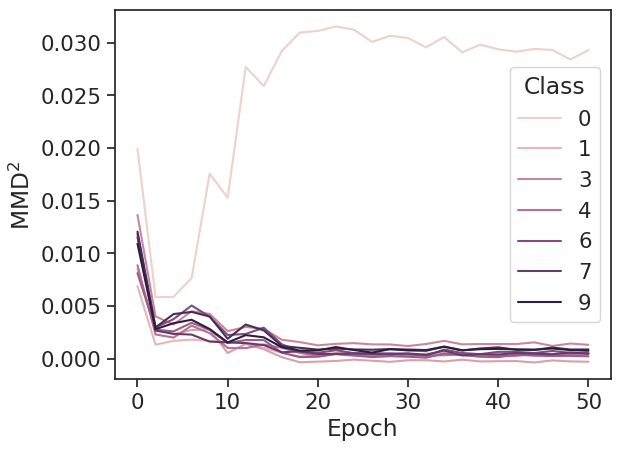

In [37]:
plot = sns.lineplot(data=exp_results, y='sMMD', x='Epoch', hue='Class')
plot.set(ylabel='MMD$^2$', xlabel='Epoch')
plot.figure.savefig('plots/mmd_per_epoch_frac{}.svg'.format(frac), bbox_inches='tight')
plot.figure.show();

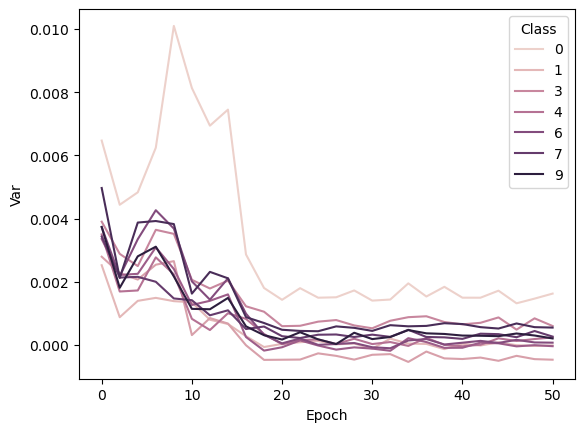

In [14]:
plot = sns.lineplot(data=exp_results, y='Var', x='Epoch', hue='Class')
plot.figure.savefig('plots/var_per_epoch_frac{}.svg'.format(frac), bbox_inches='tight')
plot.figure.show();

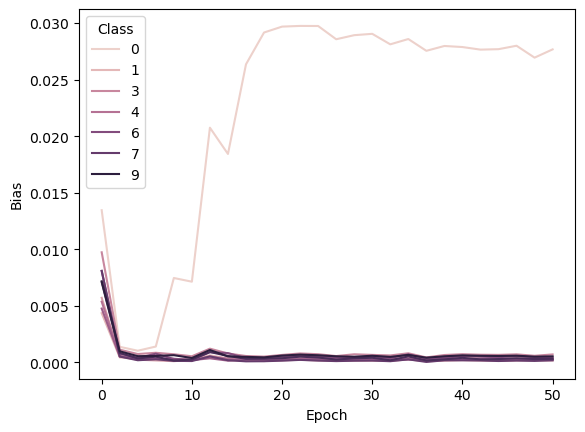

In [15]:
plot = sns.lineplot(data=exp_results, y='Bias', x='Epoch', hue='Class')
plot.figure.savefig('plots/bias_per_epoch_frac{}.svg'.format(frac), bbox_inches='tight')
plot.figure.show();

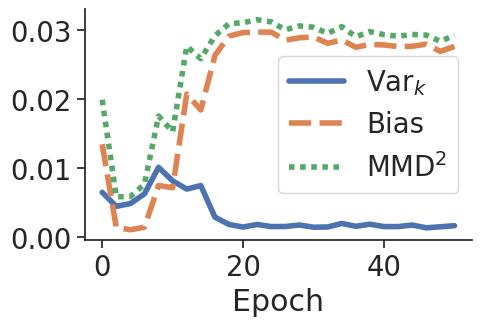

In [63]:
### Figure 5
sns.set(font_scale=1.8)
sns.set_style('ticks')
plt.figure(figsize=(5, 3))
line_size = 4
sub_results = exp_results[exp_results['Class']==0].copy()
sub_results[['Var$_k$', 'Bias', 'MMD$^2$']] = sub_results[['Var', 'Bias', 'sMMD']]
sub_results.index = range(0, 52, 2)
plot = sns.lineplot(data=sub_results[['Var$_k$', 'Bias', 'MMD$^2$']], linewidth=line_size)
plot.set(xlabel='Epoch')
sns.despine()
leg = plt.legend()
for line in leg.get_lines():
    line.set_linewidth(4)
plot.figure.savefig('plots/bias_var_mmd_per_epoch_frac{}.pdf'.format(frac), bbox_inches='tight')
plot.figure.show();

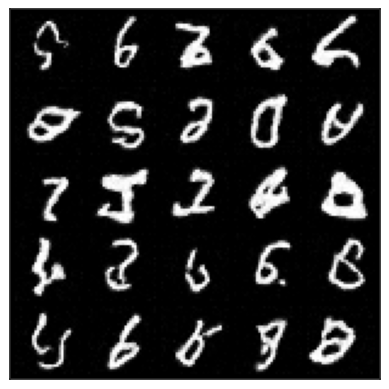

In [64]:
xs_gen = torch.load('models/infimnist/ddpm/generated_frac{}/xs_gen_ep20.pth'.format(frac)).clamp_(0, 1)
grid = make_grid(xs_gen[0][0:5,:,:,:,:][:,0:5,:,:,:].flatten(0,1), nrow=5)
show(grid)

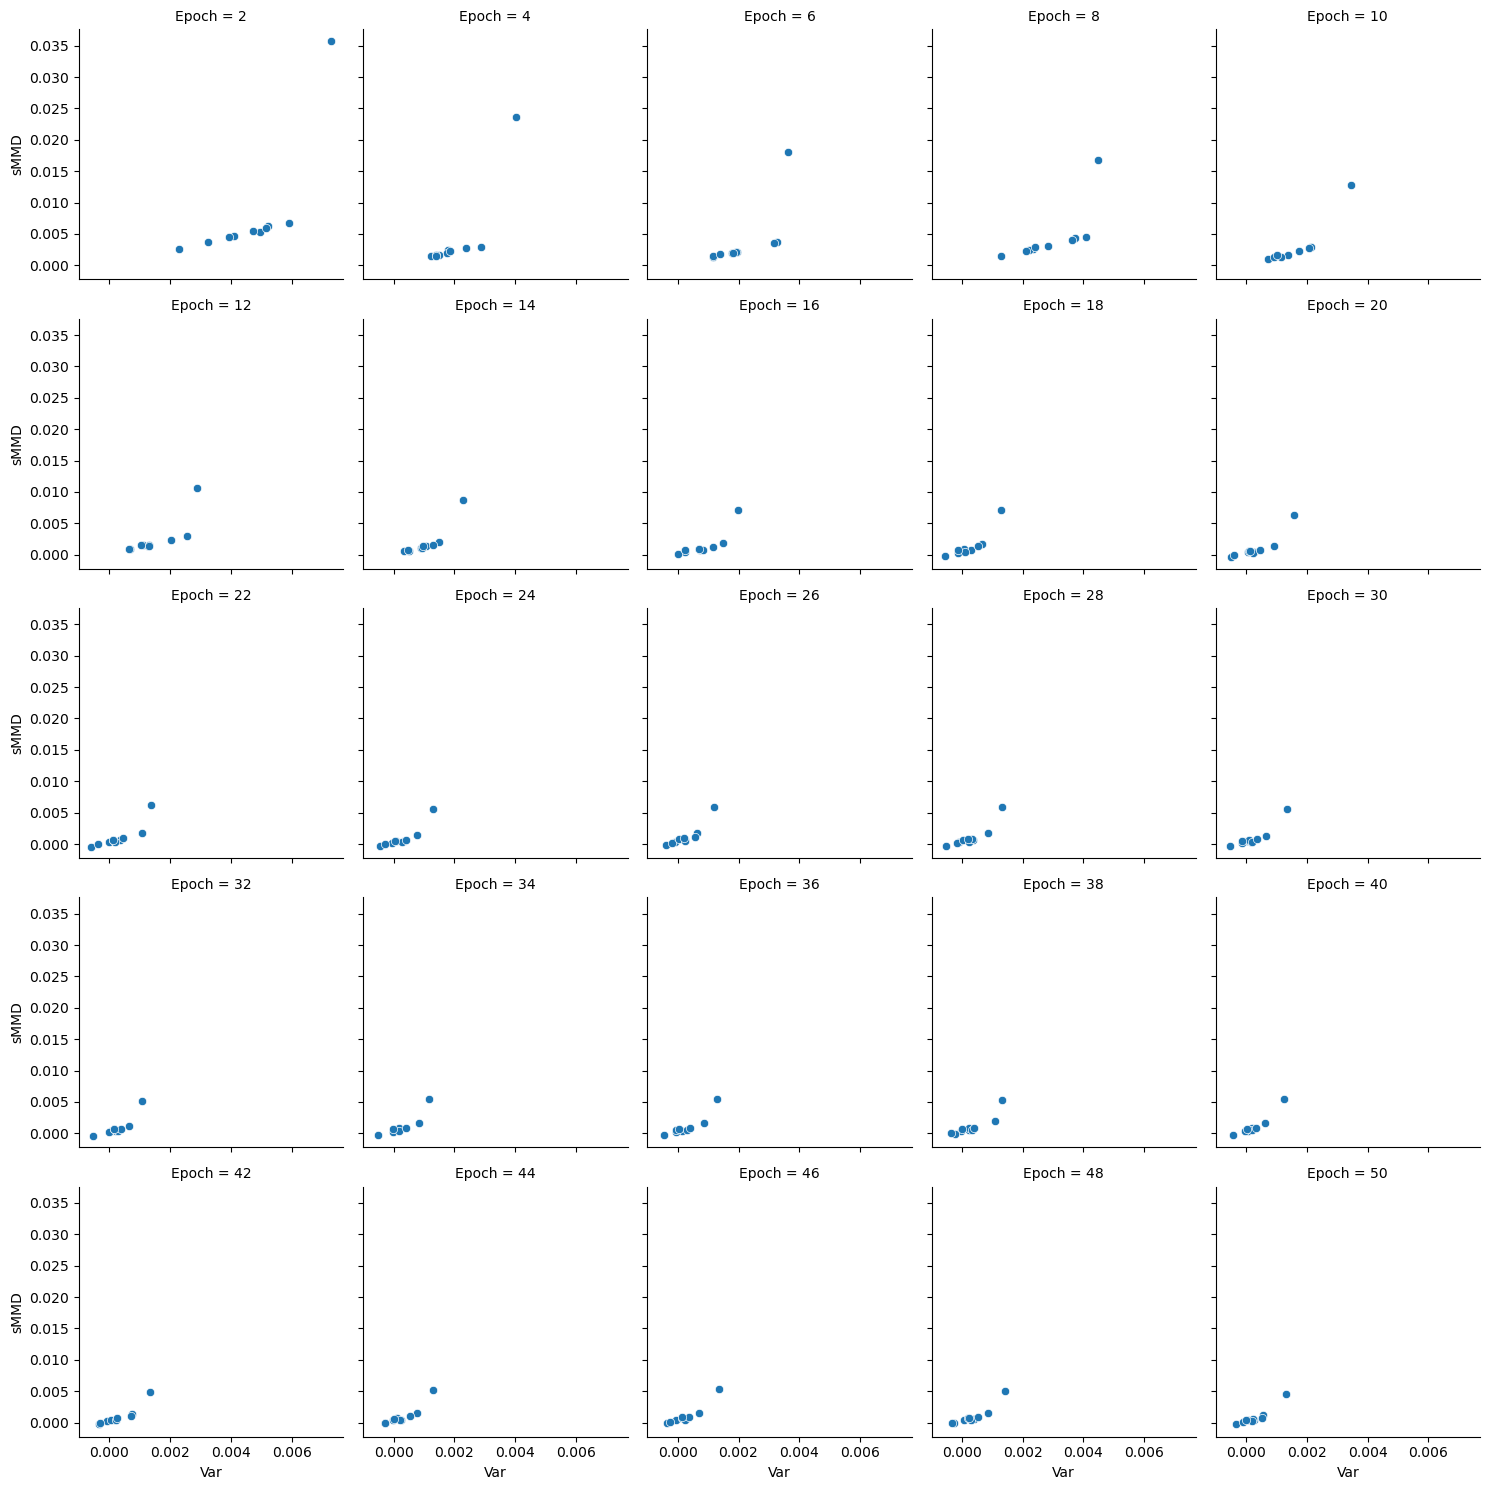

In [11]:
g = sns.FacetGrid(data=exp_results[exp_results['Epoch'].isin(range(2, 51, 2))], col="Epoch", col_wrap=5)
plot = g.map(sns.scatterplot, 'Var', 'sMMD')
plot.figure.savefig('plots/mmd_vs_var_per_epoch_frac{}.svg'.format(frac), bbox_inches='tight')
plot.figure.show();

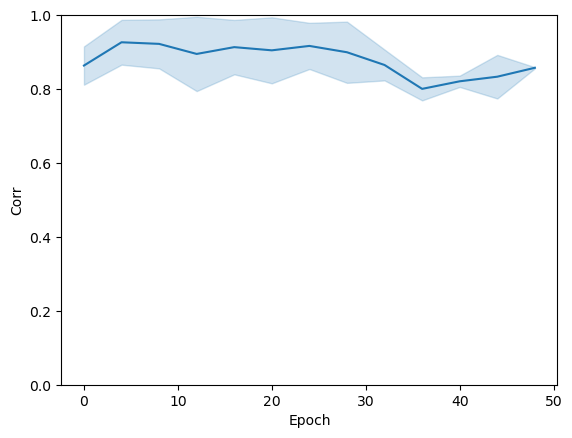

In [21]:
# Pearson correlation between sMMD and variance throughout epochs
exp_results['Corr'] = exp_results.groupby('Epoch')[['Var','sMMD']].corr(method='pearson').reset_index()['sMMD'][range(0,51,2)]
sns.lineplot(data=exp_results, y='Corr', x='Epoch').set(ylim=(0,1));

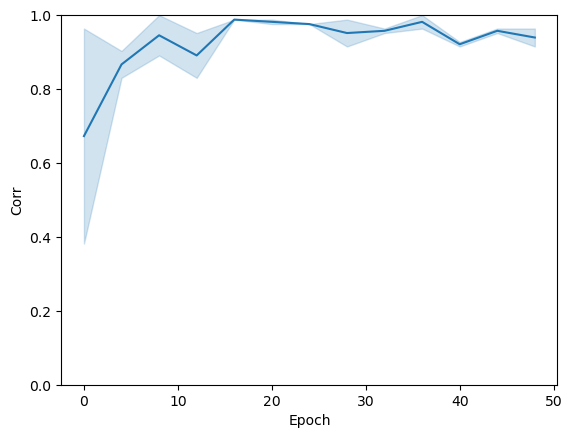

In [69]:
# spearman correlation between sMMD and variance throughout epochs
exp_results['Corr'] = exp_results.groupby('Epoch')[['Var','sMMD']].corr(method='spearman').reset_index()['sMMD'][range(0,51,2)]
sns.lineplot(data=exp_results, y='Corr', x='Epoch').set(ylim=(0,1));

In [70]:
# ~ 5 minutes
gen_folder = 'models/infimnist/ddpm/generated_frac{}/'.format(frac)
corr_matrix = epoch_correlations(gen_folder, range(0,41,2))
#corr_matrices_60_80 = epoch_correlations(gen_folder, range(60, 80))
#corr_matrices_120_140 = epoch_correlations(gen_folder, range(120, 140))
torch.save(corr_matrix, 'results/frac{}_corr_matrices.pth'.format(frac))

Epochs i:   0%|          | 0/26 [00:00<?, ?it/s]

Epochs j:   0%|          | 0/26 [00:00<?, ?it/s]

Epochs j:   0%|          | 0/26 [00:00<?, ?it/s]

Epochs j:   0%|          | 0/26 [00:00<?, ?it/s]

Epochs j:   0%|          | 0/26 [00:00<?, ?it/s]

Epochs j:   0%|          | 0/26 [00:00<?, ?it/s]

Epochs j:   0%|          | 0/26 [00:00<?, ?it/s]

Epochs j:   0%|          | 0/26 [00:00<?, ?it/s]

Epochs j:   0%|          | 0/26 [00:00<?, ?it/s]

Epochs j:   0%|          | 0/26 [00:00<?, ?it/s]

Epochs j:   0%|          | 0/26 [00:00<?, ?it/s]

Epochs j:   0%|          | 0/26 [00:00<?, ?it/s]

Epochs j:   0%|          | 0/26 [00:00<?, ?it/s]

Epochs j:   0%|          | 0/26 [00:00<?, ?it/s]

Epochs j:   0%|          | 0/26 [00:00<?, ?it/s]

Epochs j:   0%|          | 0/26 [00:00<?, ?it/s]

Epochs j:   0%|          | 0/26 [00:00<?, ?it/s]

Epochs j:   0%|          | 0/26 [00:00<?, ?it/s]

Epochs j:   0%|          | 0/26 [00:00<?, ?it/s]

Epochs j:   0%|          | 0/26 [00:00<?, ?it/s]

Epochs j:   0%|          | 0/26 [00:00<?, ?it/s]

Epochs j:   0%|          | 0/26 [00:00<?, ?it/s]

Epochs j:   0%|          | 0/26 [00:00<?, ?it/s]

Epochs j:   0%|          | 0/26 [00:00<?, ?it/s]

Epochs j:   0%|          | 0/26 [00:00<?, ?it/s]

Epochs j:   0%|          | 0/26 [00:00<?, ?it/s]

Epochs j:   0%|          | 0/26 [00:00<?, ?it/s]

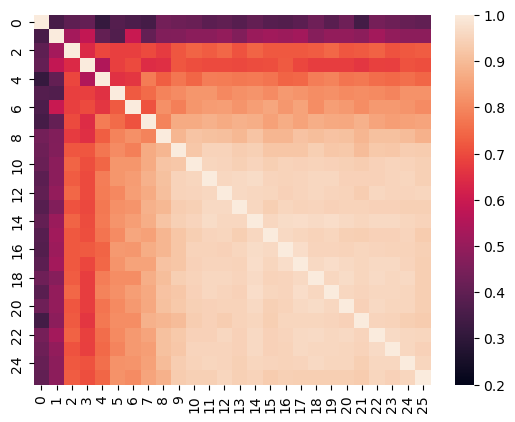

In [42]:
class_i = 0
sns.heatmap(corr_matrices_0_20[class_i], vmin=0.2, vmax=1, xticklabels=range(0, 41, 2), yticklabels=range(0, 41, 2));

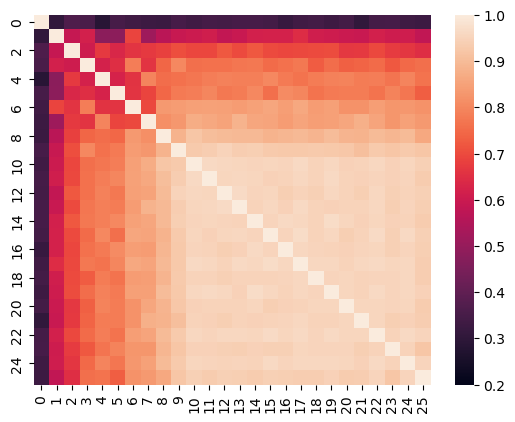

In [43]:
class_i = 1
sns.heatmap(corr_matrices_0_20[class_i], vmin=0.2, vmax=1, xticklabels=range(0, 41, 2), yticklabels=range(0, 41, 2));

In [7]:
load_file = 'models/infimnist/ddpm/generated_frac{}/xs_gen_ep{}.pth'
fracs = [0.01, 0.02, 0.03, 0.04, 0.05, 0.1, 0.2, 0.4, 0.6, 0.8, 1.0]
exp_results = metrics_per_frac(load_file, fracs=fracs)
torch.save(exp_results, 'results/metrics_per_class_epoch_frac.pth')

Classes:   0%|          | 0/10 [00:00<?, ?it/s]

Fracs:   0%|          | 0/11 [00:00<?, ?it/s]

Fracs:   0%|          | 0/11 [00:00<?, ?it/s]

Fracs:   0%|          | 0/11 [00:00<?, ?it/s]

Fracs:   0%|          | 0/11 [00:00<?, ?it/s]

Fracs:   0%|          | 0/11 [00:00<?, ?it/s]

Fracs:   0%|          | 0/11 [00:00<?, ?it/s]

Fracs:   0%|          | 0/11 [00:00<?, ?it/s]

Fracs:   0%|          | 0/11 [00:00<?, ?it/s]

Fracs:   0%|          | 0/11 [00:00<?, ?it/s]

Fracs:   0%|          | 0/11 [00:00<?, ?it/s]

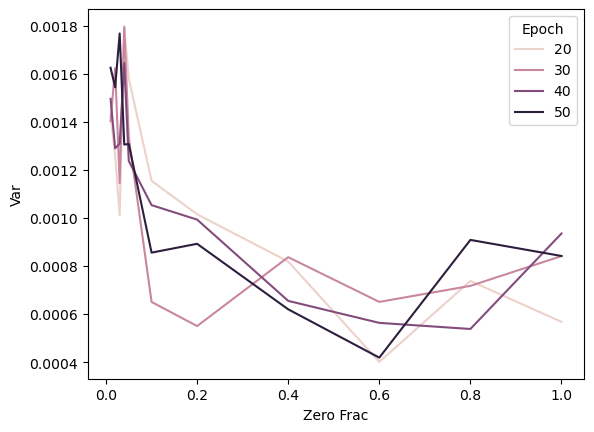

In [9]:
exp_results = torch.load('results/metrics_per_class_epoch_frac.pth')
exp_results['Bias'] = exp_results['GE'] - exp_results['Noise'] - exp_results['Var']
sub_results = exp_results[exp_results['Epoch'].isin(range(20, 51, 10)) & (exp_results['Class']==0)]
plot = sns.lineplot(data=sub_results, y='Var', x='Zero Frac', hue='Epoch')
#plot.set(xscale='log')
plot.figure.show();

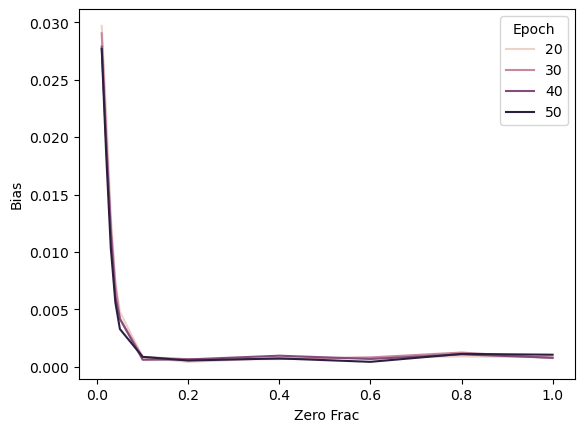

In [10]:
sub_results = exp_results[exp_results['Epoch'].isin(range(20, 51, 10)) & (exp_results['Class']==0)]# & exp_results['Zero Frac'].isin(np.arange(0.01, 0.06, 0.01))]
plot = sns.lineplot(data=sub_results, y='Bias', x='Zero Frac', hue='Epoch')
#plot.set(xscale='log')
plot.figure.show();

In [46]:
# RUN THIS CELL FOR THE FOLLOWING PLOTS (~1 minutes)
frac = 0.01
class_reduced = 3
gen_folder = 'models/infimnist/ddpm/generated_frac{}_class{}/'.format(frac, class_reduced)
epochs = range(0, 41, 2)
ddpm_ids = range(10)
exp_results = metrics_per_epoch_class(gen_folder, epochs)
torch.save(exp_results, 'results/frac{}_metrics_per_class{}.pth'.format(frac, class_reduced))

Classes:   0%|          | 0/10 [00:00<?, ?it/s]

Epochs:   0%|          | 0/21 [00:00<?, ?it/s]

Epochs:   0%|          | 0/21 [00:00<?, ?it/s]

Epochs:   0%|          | 0/21 [00:00<?, ?it/s]

Epochs:   0%|          | 0/21 [00:00<?, ?it/s]

Epochs:   0%|          | 0/21 [00:00<?, ?it/s]

Epochs:   0%|          | 0/21 [00:00<?, ?it/s]

Epochs:   0%|          | 0/21 [00:00<?, ?it/s]

Epochs:   0%|          | 0/21 [00:00<?, ?it/s]

Epochs:   0%|          | 0/21 [00:00<?, ?it/s]

Epochs:   0%|          | 0/21 [00:00<?, ?it/s]

In [53]:
frac = 0.01
class_reduced = 2
exp_results = torch.load('results/frac{}_metrics_per_class{}.pth'.format(frac, class_reduced))
exp_results['sMMD'] = exp_results['GE'] - exp_results['Noise']
exp_results['Bias'] = exp_results['sMMD'] - exp_results['Var']

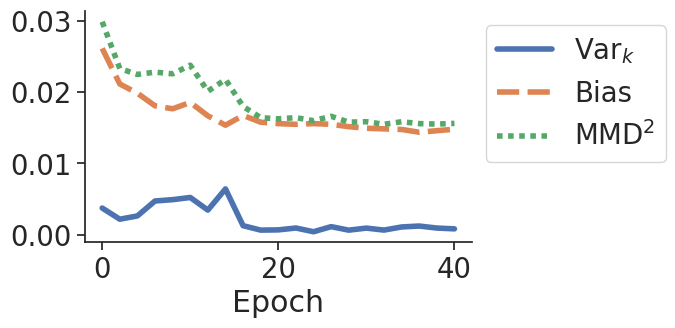

In [54]:
### Figure 9 Left
### Figure 9 Right if `class_reduced = 3` in the previous cell
sns.set(font_scale=1.8)
sns.set_style('ticks')
plt.figure(figsize=(5, 3))
line_size = 4
sub_results = exp_results[exp_results['Class']==class_reduced].copy()
sub_results[['Var$_k$', 'Bias', 'MMD$^2$']] = sub_results[['Var', 'Bias', 'sMMD']]
sub_results.index = range(0, 42, 2)
plot = sns.lineplot(data=sub_results[['Var$_k$', 'Bias', 'MMD$^2$']], linewidth=line_size)
plot.set(xlabel='Epoch')
sns.despine()
leg = plt.legend()
for line in leg.get_lines():
    line.set_linewidth(4)
sns.move_legend(plot, "upper left", bbox_to_anchor=(1, 1))
save_file = 'plots/bias_var_mmd_per_epoch_frac{}_class{}.svg'.format(frac, class_reduced)
plot.figure.savefig(save_file, bbox_inches='tight')
plot.figure.show();

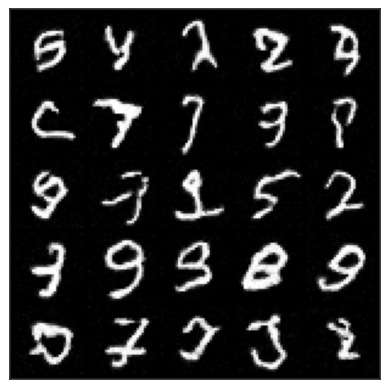

In [49]:
xs_gen = torch.load('models/infimnist/ddpm/generated_frac{}_class{}/xs_gen_ep20.pth'.format(frac, class_reduced)).clamp_(0, 1)
grid = make_grid(xs_gen[class_reduced][0:5,:,:,:,:][:,0:5,:,:,:].flatten(0,1), nrow=5)
show(grid)

In [ ]:
########################################
### DEEP ENSEMBLE (only 1 train set) ###
########################################

In [6]:
# RUN THIS CELL FOR THE FOLLOWING PLOTS (~1 minutes)
gen_folder = 'models/infimnist/ddpm/generated_frac1.0_DE/'
epochs = range(0, 51, 2)
ddpm_ids = range(20)
exp_results = metrics_per_epoch_class(gen_folder, epochs)
torch.save(exp_results, 'results/DE_metrics_per_class.pth')

Classes:   0%|          | 0/10 [00:00<?, ?it/s]

Epochs:   0%|          | 0/26 [00:00<?, ?it/s]

Epochs:   0%|          | 0/26 [00:00<?, ?it/s]

Epochs:   0%|          | 0/26 [00:00<?, ?it/s]

Epochs:   0%|          | 0/26 [00:00<?, ?it/s]

Epochs:   0%|          | 0/26 [00:00<?, ?it/s]

Epochs:   0%|          | 0/26 [00:00<?, ?it/s]

Epochs:   0%|          | 0/26 [00:00<?, ?it/s]

Epochs:   0%|          | 0/26 [00:00<?, ?it/s]

Epochs:   0%|          | 0/26 [00:00<?, ?it/s]

Epochs:   0%|          | 0/26 [00:00<?, ?it/s]

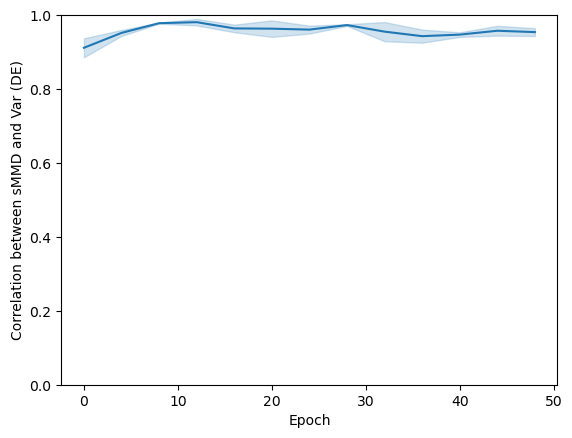

In [11]:
exp_results = torch.load('results/DE_metrics_per_class.pth')

# Pearson correlation between sMMD and variance throughout epochs
exp_results['sMMD'] = exp_results['GE'] - exp_results['Noise']
exp_results['Corr'] = exp_results.groupby('Epoch')[['Var','sMMD']].corr(method='pearson').reset_index()['sMMD'][range(0,51,2)]
plot = sns.lineplot(data=exp_results, y='Corr', x='Epoch')
plot.set(ylabel='Correlation between sMMD and Var (DE)', ylim=(0,1))
plot.figure.savefig('plots/corr_default_DE.svg', bbox_inches='tight')
plot.figure.show();

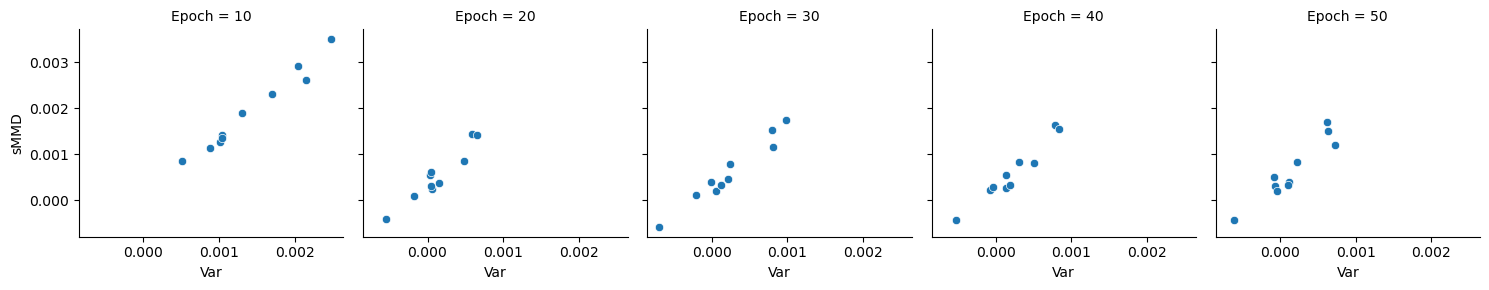

In [60]:
g = sns.FacetGrid(data=exp_results[exp_results['Epoch'].isin(range(10, 51, 10))], col="Epoch", col_wrap=5)
plot = g.map(sns.scatterplot, 'Var', 'sMMD')
plot.figure.savefig('plots/mmd_vs_var_per_epoch_frac1.0_DE.svg', bbox_inches='tight')
plot.figure.show();

In [34]:
# ~3 minutes
gen_folder = 'models/infimnist/ddpm/generated_frac1.0_DE/'
corr_matrix = epoch_correlations(gen_folder, range(0, 41, 2))
torch.save(corr_matrix, 'results/DE_corr_matrices.pth')

Epochs i:   0%|          | 0/21 [00:00<?, ?it/s]

Epochs j:   0%|          | 0/21 [00:00<?, ?it/s]

Epochs j:   0%|          | 0/21 [00:00<?, ?it/s]

Epochs j:   0%|          | 0/21 [00:00<?, ?it/s]

Epochs j:   0%|          | 0/21 [00:00<?, ?it/s]

Epochs j:   0%|          | 0/21 [00:00<?, ?it/s]

Epochs j:   0%|          | 0/21 [00:00<?, ?it/s]

Epochs j:   0%|          | 0/21 [00:00<?, ?it/s]

Epochs j:   0%|          | 0/21 [00:00<?, ?it/s]

Epochs j:   0%|          | 0/21 [00:00<?, ?it/s]

Epochs j:   0%|          | 0/21 [00:00<?, ?it/s]

Epochs j:   0%|          | 0/21 [00:00<?, ?it/s]

Epochs j:   0%|          | 0/21 [00:00<?, ?it/s]

Epochs j:   0%|          | 0/21 [00:00<?, ?it/s]

Epochs j:   0%|          | 0/21 [00:00<?, ?it/s]

Epochs j:   0%|          | 0/21 [00:00<?, ?it/s]

Epochs j:   0%|          | 0/21 [00:00<?, ?it/s]

Epochs j:   0%|          | 0/21 [00:00<?, ?it/s]

Epochs j:   0%|          | 0/21 [00:00<?, ?it/s]

Epochs j:   0%|          | 0/21 [00:00<?, ?it/s]

Epochs j:   0%|          | 0/21 [00:00<?, ?it/s]

Epochs j:   0%|          | 0/21 [00:00<?, ?it/s]

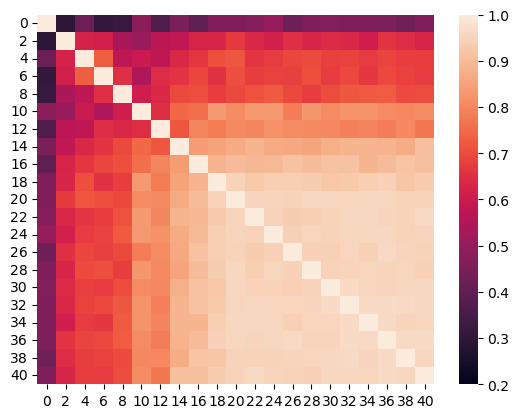

In [35]:
corr_matrices = torch.load('results/DE_corr_matrices.pth')
class_i = 0
plot = sns.heatmap(corr_matrices[class_i], vmin=0.2, vmax=1, xticklabels=range(0, 41, 2), yticklabels=range(0, 41, 2))
#plot.set(ylabel='Correlation between sMMD and Var', ylim=(0,1))
plot.figure.savefig('plots/corr_matrix_{}_DE.svg'.format(class_i), bbox_inches='tight')
plot.figure.show();

In [5]:
### COMBINATIONS

In [ ]:
exp_results = torch.load('results/frac1.0_metrics_per_class.pth')
exp_results = exp_results[exp_results['Epoch']<=40]
exp_results['sMMD'] = exp_results['GE'] - exp_results['Noise']

de_results = torch.load('results/DE_metrics_per_class.pth')
de_results = de_results[de_results['Epoch']<=40]
de_results['sMMD'] = de_results['GE'] - de_results['Noise']
corr_df = pd.DataFrame({
    'MMD$^2$ vs Var$_k$': exp_results.groupby('Epoch')[['Var','sMMD']].corr(method='pearson').reset_index()['sMMD'][range(0,41,2)],
    'MMD$^2$ vs Var$_k$ \n(deep ensemble)': de_results.groupby('Epoch')[['Var','sMMD']].corr(method='pearson').reset_index()['sMMD'][range(0,41,2)],
    'Kernel score vs \n kernel entropy': exp_results.groupby('Epoch')[['PK Ent','GE']].corr(method='pearson').reset_index()['GE'][range(0,41,2)],
    'Kernel score vs \n Var$_k$': exp_results.groupby('Epoch')[['Var','GE']].corr(method='pearson').reset_index()['GE'][range(0,41,2)],
    #'MMD$^2$ vs Kernel Entropy': exp_results.groupby('Epoch')[['PK Ent','sMMD']].corr(method='pearson').reset_index()['sMMD'][range(0,41,2)],
})

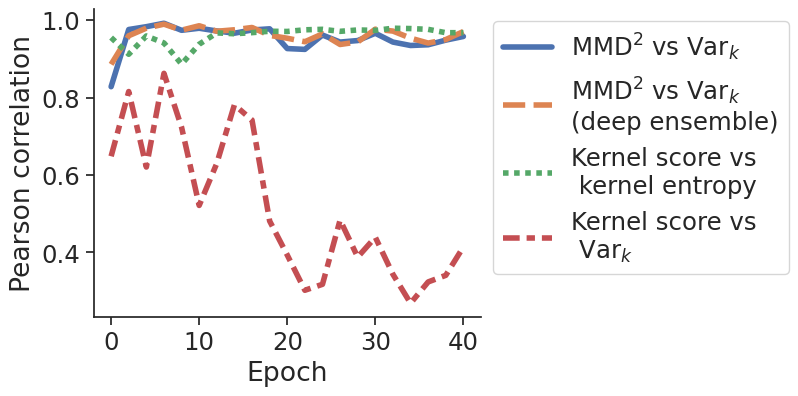

In [11]:
### Figure 4 Right
plt.figure(figsize=(5, 4))
sns.set(font_scale=1.6)
sns.set_style('ticks')
line_size = 4
plot = sns.lineplot(corr_df, linewidth=line_size)
plot.set(ylabel='Pearson correlation', xlabel='Epoch')
sns.despine()
leg = plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
for line in leg.get_lines():
    line.set_linewidth(4)
plot.figure.savefig('plots/corr_default_combo.svg', bbox_inches='tight')
plot.figure.show();

/home/sgruber/miniconda3/envs/TTS/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


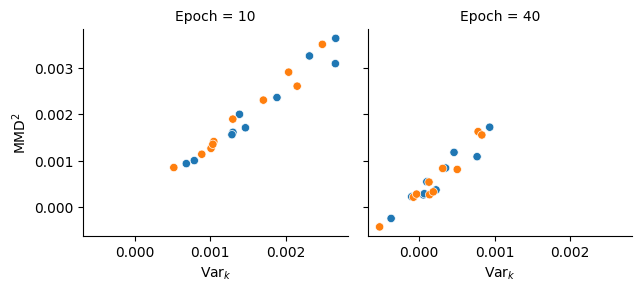

In [52]:
sub_results = exp_results[(exp_results['Epoch'].isin(range(10, 41, 30)))&(exp_results['Comparison'].isin(['MMD$^2$ vs Var$_k$', 'MMD$^2$ vs Var$_k$ (Deep Ensemble)']))]
g = sns.FacetGrid(data=sub_results, col="Epoch", col_wrap=5)
plot = g.map(sns.scatterplot, 'Var', 'sMMD', 'Comparison')
plot.set(ylabel='MMD$^2$', xlabel='Var$_k$')
plot.add_legend()
save_name = 'plots/mmd_vs_var_per_epoch_combo'
plot.figure.savefig(save_name+'.pdf', bbox_inches='tight')
plot.figure.savefig(save_name+'.png', bbox_inches='tight')
plot.figure.show();

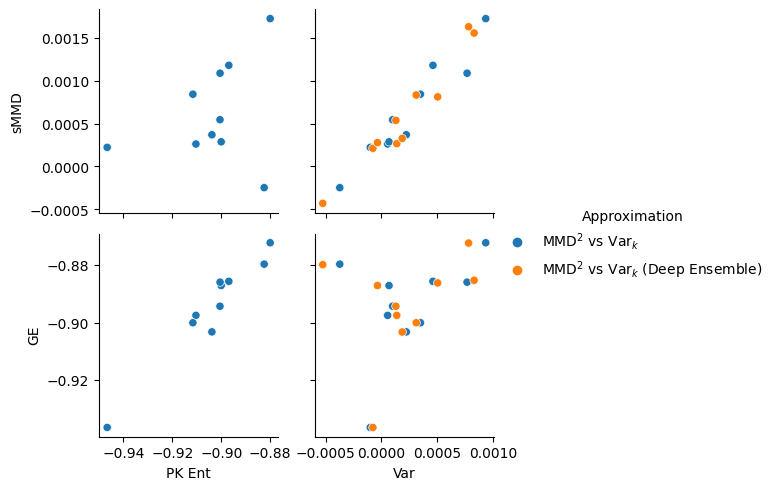

In [57]:
sub_results = exp_results[(exp_results['Epoch'].isin([40]))&(exp_results['Comparison'].isin(['MMD$^2$ vs Var$_k$', 'MMD$^2$ vs Var$_k$ (Deep Ensemble)']))].copy()
sub_results['Approximation'] = sub_results['Comparison']
x_vars = ['PK Ent', 'Var']
y_vars = ['sMMD', 'GE']
#g = sns.PairGrid(sub_results, x_vars=x_vars, y_vars=y_vars, hue='Epoch')
plot = sns.PairGrid(sub_results, x_vars=x_vars, y_vars=y_vars, hue='Approximation')
plot.map(sns.scatterplot)
plot.add_legend()
plot.figure.savefig('plots/scatter_pke_var_vs_smmd_ge_DE.svg', bbox_inches='tight')
plot.figure.show();

In [43]:
####################################
### GROUND TRUTH 100% TRAIN DATA ###
####################################
### OTHER KERNELS ###############

### Figure 10
# kernel_lap = lambda x, y: metrics.pairwise.laplacian_kernel(x, y)
# kernel_str = 'kernel_lap'

# kernel_lap = lambda x, y: metrics.pairwise.cosine_similarity(x, y)
# kernel_str = 'kernel_cos'

### Figure 11
kernel_lap = lambda x, y: metrics.pairwise.polynomial_kernel(x, y)
kernel_str = 'kernel_pol'

In [44]:
# RUN THIS CELL FOR THE FOLLOWING PLOTS (<5 minutes)
gen_folder = 'models/infimnist/ddpm/generated_frac1.0/'
epochs = range(0, 41, 2)
ddpm_ids = range(20)
exp_results = metrics_per_epoch_class(gen_folder, epochs, kernel=kernel_lap)
torch.save(exp_results, 'results/frac1.0_metrics_per_class_{}.pth'.format(kernel_str))

# ~ 19 minutes (RTX 5000)
gen_folder = 'models/infimnist/ddpm/generated_frac1.0/'
corr_matrices = epoch_correlations(gen_folder, range(0,41,2), kernel=kernel_lap)
torch.save(corr_matrices, 'results/frac1.0_corr_matrices_{}.pth'.format(kernel_str))

# RUN THIS CELL FOR THE FOLLOWING PLOTS (~1 minutes)
frac = 0.01
gen_folder = 'models/infimnist/ddpm/generated_frac{}/'.format(frac)
epochs = range(0, 51, 2)
ddpm_ids = range(20)
exp_results = metrics_per_epoch_class(gen_folder, epochs, kernel=kernel_lap)
torch.save(exp_results, 'results/frac{}_metrics_per_class_{}.pth'.format(frac, kernel_str))

# RUN THIS CELL FOR THE FOLLOWING PLOTS (~1 minutes)
gen_folder = 'models/infimnist/ddpm/generated_frac1.0_DE/'
epochs = range(0, 51, 2)
ddpm_ids = range(20)
exp_results = metrics_per_epoch_class(gen_folder, epochs, kernel=kernel_lap)
torch.save(exp_results, 'results/DE_metrics_per_class_{}.pth'.format(kernel_str))

Classes:   0%|          | 0/10 [00:00<?, ?it/s]

Epochs:   0%|          | 0/21 [00:00<?, ?it/s]

Epochs:   0%|          | 0/21 [00:00<?, ?it/s]

Epochs:   0%|          | 0/21 [00:00<?, ?it/s]

Epochs:   0%|          | 0/21 [00:00<?, ?it/s]

Epochs:   0%|          | 0/21 [00:00<?, ?it/s]

Epochs:   0%|          | 0/21 [00:00<?, ?it/s]

Epochs:   0%|          | 0/21 [00:00<?, ?it/s]

Epochs:   0%|          | 0/21 [00:00<?, ?it/s]

Epochs:   0%|          | 0/21 [00:00<?, ?it/s]

Epochs:   0%|          | 0/21 [00:00<?, ?it/s]

Epochs i:   0%|          | 0/21 [00:00<?, ?it/s]

Epochs j:   0%|          | 0/21 [00:00<?, ?it/s]

Epochs j:   0%|          | 0/21 [00:00<?, ?it/s]

Epochs j:   0%|          | 0/21 [00:00<?, ?it/s]

Epochs j:   0%|          | 0/21 [00:00<?, ?it/s]

Epochs j:   0%|          | 0/21 [00:00<?, ?it/s]

Epochs j:   0%|          | 0/21 [00:00<?, ?it/s]

Epochs j:   0%|          | 0/21 [00:00<?, ?it/s]

Epochs j:   0%|          | 0/21 [00:00<?, ?it/s]

Epochs j:   0%|          | 0/21 [00:00<?, ?it/s]

Epochs j:   0%|          | 0/21 [00:00<?, ?it/s]

Epochs j:   0%|          | 0/21 [00:00<?, ?it/s]

Epochs j:   0%|          | 0/21 [00:00<?, ?it/s]

Epochs j:   0%|          | 0/21 [00:00<?, ?it/s]

Epochs j:   0%|          | 0/21 [00:00<?, ?it/s]

Epochs j:   0%|          | 0/21 [00:00<?, ?it/s]

Epochs j:   0%|          | 0/21 [00:00<?, ?it/s]

Epochs j:   0%|          | 0/21 [00:00<?, ?it/s]

Epochs j:   0%|          | 0/21 [00:00<?, ?it/s]

Epochs j:   0%|          | 0/21 [00:00<?, ?it/s]

Epochs j:   0%|          | 0/21 [00:00<?, ?it/s]

Epochs j:   0%|          | 0/21 [00:00<?, ?it/s]

Classes:   0%|          | 0/10 [00:00<?, ?it/s]

Epochs:   0%|          | 0/26 [00:00<?, ?it/s]

Epochs:   0%|          | 0/26 [00:00<?, ?it/s]

Epochs:   0%|          | 0/26 [00:00<?, ?it/s]

Epochs:   0%|          | 0/26 [00:00<?, ?it/s]

Epochs:   0%|          | 0/26 [00:00<?, ?it/s]

Epochs:   0%|          | 0/26 [00:00<?, ?it/s]

Epochs:   0%|          | 0/26 [00:00<?, ?it/s]

Epochs:   0%|          | 0/26 [00:00<?, ?it/s]

Epochs:   0%|          | 0/26 [00:00<?, ?it/s]

Epochs:   0%|          | 0/26 [00:00<?, ?it/s]

Classes:   0%|          | 0/10 [00:00<?, ?it/s]

Epochs:   0%|          | 0/26 [00:00<?, ?it/s]

Epochs:   0%|          | 0/26 [00:00<?, ?it/s]

Epochs:   0%|          | 0/26 [00:00<?, ?it/s]

Epochs:   0%|          | 0/26 [00:00<?, ?it/s]

Epochs:   0%|          | 0/26 [00:00<?, ?it/s]

Epochs:   0%|          | 0/26 [00:00<?, ?it/s]

Epochs:   0%|          | 0/26 [00:00<?, ?it/s]

Epochs:   0%|          | 0/26 [00:00<?, ?it/s]

Epochs:   0%|          | 0/26 [00:00<?, ?it/s]

Epochs:   0%|          | 0/26 [00:00<?, ?it/s]

In [45]:
exp_results = torch.load('results/frac1.0_metrics_per_class_{}.pth'.format(kernel_str))
exp_results = exp_results[exp_results['Epoch']<=40]
exp_results['sMMD'] = exp_results['GE'] - exp_results['Noise']
exp_results['Bias'] = exp_results['sMMD'] - exp_results['Var']

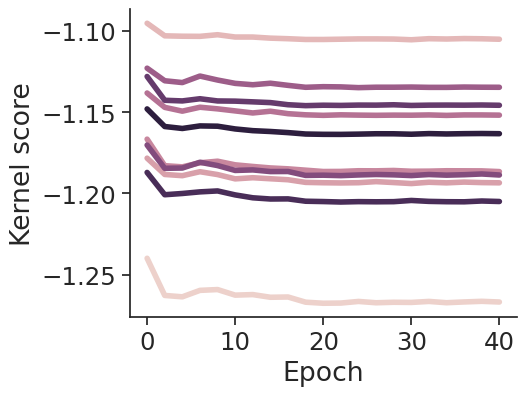

In [46]:
sns.set(font_scale=1.6)
sns.set_style('ticks')
plt.figure(figsize=(5, 4))
line_size = 4
plot = sns.lineplot(data=exp_results, y='GE', x='Epoch', hue='Class', linewidth=line_size, legend=False)
plot.set(ylabel='Kernel score', xlabel='Epoch')
sns.despine()
plot.figure.savefig('plots/ge_per_epoch_frac1.0_{}.pdf'.format(kernel_str), bbox_inches='tight')
plot.figure.show();

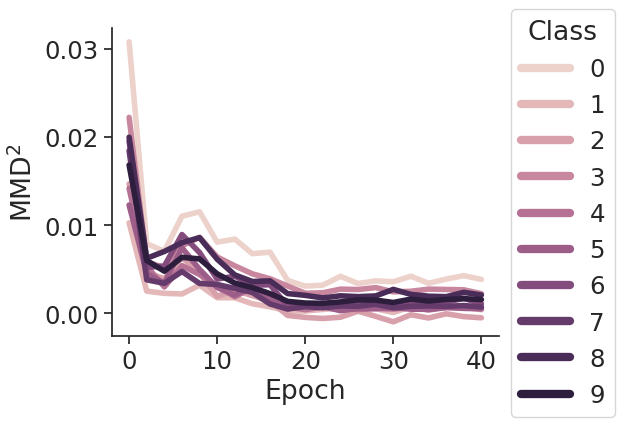

In [47]:
sns.set(font_scale=1.6)
sns.set_style('ticks')
plt.figure(figsize=(5, 4))
line_size = 4
plot = sns.lineplot(
    data=exp_results,
    y='sMMD',
    x='Epoch',
    hue='Class',
    linewidth=line_size,
    legend='full',
)
plot.set(ylabel='MMD$^2$', xlabel='Epoch')
sns.despine()
leg = plt.legend(title='Class')
for line in leg.get_lines():
    line.set_linewidth(6)
sns.move_legend(plot, "upper left", bbox_to_anchor=(1, 1.1))
plot.figure.savefig('plots/mmd_per_epoch_frac1.0_{}.pdf'.format(kernel_str), bbox_inches='tight')
plot.figure.show();

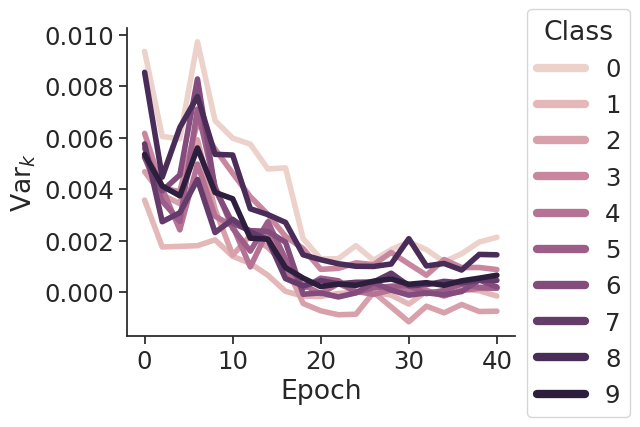

In [48]:
sns.set(font_scale=1.6)
sns.set_style('ticks')
plt.figure(figsize=(5, 4))
line_size = 4
plot = sns.lineplot(data=exp_results, y='Var', x='Epoch', hue='Class', linewidth=line_size, legend='full')
sns.despine()
plot.set(ylabel='Var$_k$', xlabel='Epoch')
leg = plt.legend(title='Class')
for line in leg.get_lines():
    line.set_linewidth(6)
sns.move_legend(plot, "upper left", bbox_to_anchor=(1, 1.1))
plot.figure.savefig('plots/var_per_epoch_frac1.0_{}.pdf'.format(kernel_str), bbox_inches='tight')
plot.figure.show();

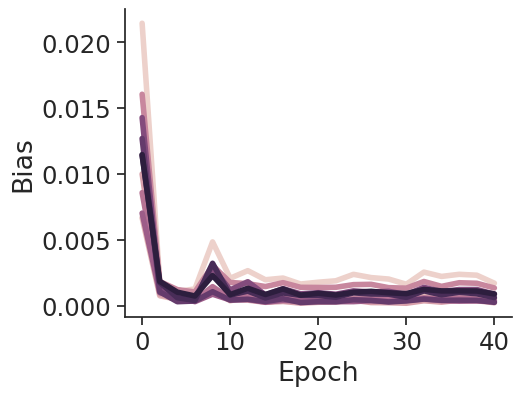

In [49]:
sns.set(font_scale=1.6)
sns.set_style('ticks')
plt.figure(figsize=(5, 4))
line_size = 4
plot = sns.lineplot(data=exp_results, y='Bias', x='Epoch', hue='Class', linewidth=line_size, legend=False)
sns.despine()
plot.set(ylabel='Bias', xlabel='Epoch')
plot.figure.savefig('plots/bias_per_epoch_frac1.0_{}.pdf'.format(kernel_str), bbox_inches='tight')
plot.figure.show();

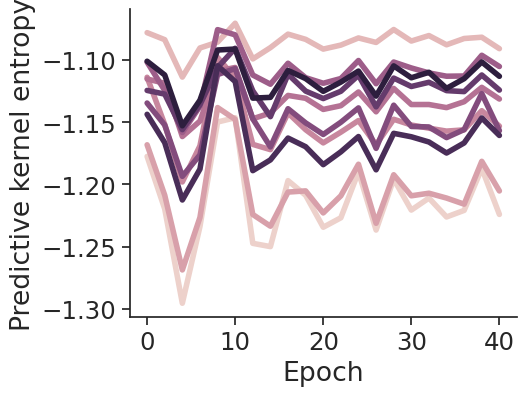

In [50]:
sns.set(font_scale=1.6)
sns.set_style('ticks')
plt.figure(figsize=(5, 4))
line_size = 4
plot = sns.lineplot(data=exp_results, y='PK Ent', x='Epoch', hue='Class', linewidth=line_size, legend=False)
sns.despine()
plot.set(ylabel='Predictive kernel entropy', xlabel='Epoch')
plot.figure.savefig('plots/pkent_per_epoch_frac1.0_{}.pdf'.format(kernel_str), bbox_inches='tight')
plot.figure.show();

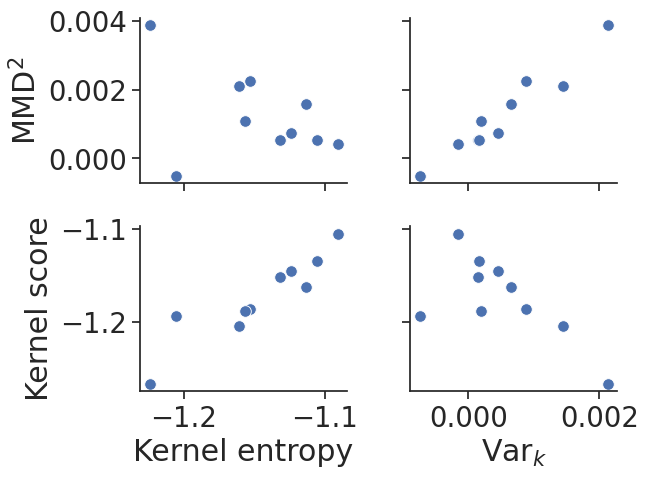

In [51]:
sub_results = exp_results[exp_results['Epoch'].isin([40])]
x_vars = ['PK Ent', 'Var']
y_vars = ['sMMD', 'GE']
sns.set(font_scale=1.8)
sns.set_style('ticks')
plot = sns.PairGrid(sub_results, x_vars=x_vars, y_vars=y_vars, aspect=1.2)
plot.map(sns.scatterplot, s=70)
plot.add_legend()
plot.axes[0,0].yaxis.set_label_text('MMD$^2$', visible=True)
plot.axes[1,0].yaxis.set_label_text('Kernel score', visible=True)
plot.axes[1,0].xaxis.set_label_text('Kernel entropy', visible=True)
plot.axes[1,1].xaxis.set_label_text('Var$_k$', visible=True)
plot.figure.savefig('plots/scatter_pke_var_vs_smmd_ge_{}.pdf'.format(kernel_str), bbox_inches='tight')
plot.figure.show();

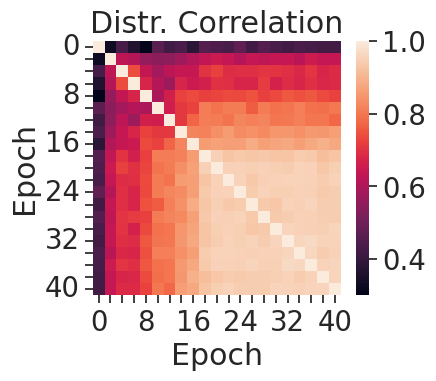

In [52]:
corr_matrices = torch.load('results/frac1.0_corr_matrices_{}.pth'.format(kernel_str))
plt.figure(figsize=(4, 3.3))
sns.set(font_scale=1.8)
sns.set_style('ticks')
ticks = [i if i%8==0 else None for i in range(0, 41, 2)]
plot = sns.heatmap(
    corr_matrices.mean(axis=0), vmin=None, vmax=1, xticklabels=ticks, yticklabels=ticks,
    cbar_kws = dict(use_gridspec=False, location="right", ticks=[0.4, 0.6, 0.8, 1.0])
)
plot.set_yticklabels(plot.get_yticklabels(), rotation = 0)
plot.set_ylabel('Epoch')
plot.set_xlabel('Epoch')
plot.set_title('Distr. Correlation')
plot.figure.savefig('plots/corr_matrix_avg_default_{}.pdf'.format(kernel_str), bbox_inches='tight')
plot.figure.show();

In [53]:
exp_results = torch.load('results/frac{}_metrics_per_class_{}.pth'.format(frac, kernel_str))
exp_results['sMMD'] = exp_results['GE'] - exp_results['Noise']
exp_results['Bias'] = exp_results['sMMD'] - exp_results['Var']

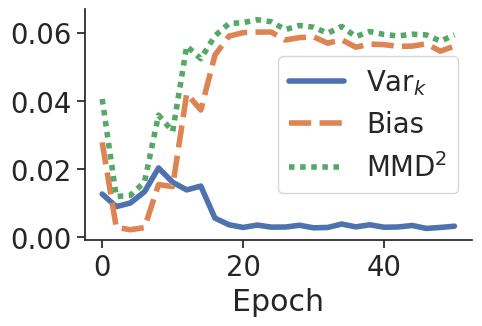

In [54]:
### Figure 12
sns.set(font_scale=1.8)
sns.set_style('ticks')
plt.figure(figsize=(5, 3))
line_size = 4
sub_results = exp_results[exp_results['Class']==0].copy()
sub_results[['Var$_k$', 'Bias', 'MMD$^2$']] = sub_results[['Var', 'Bias', 'sMMD']]
sub_results.index = range(0, 52, 2)
plot = sns.lineplot(data=sub_results[['Var$_k$', 'Bias', 'MMD$^2$']], linewidth=line_size)
plot.set(xlabel='Epoch')
sns.despine()
leg = plt.legend()
for line in leg.get_lines():
    line.set_linewidth(4)
plot.figure.savefig('plots/bias_var_mmd_per_epoch_frac{}_{}.pdf'.format(frac, kernel_str), bbox_inches='tight')
plot.figure.show();

In [55]:
exp_results = torch.load('results/frac1.0_metrics_per_class_{}.pth'.format(kernel_str))
exp_results = exp_results[exp_results['Epoch']<=40]
exp_results['sMMD'] = exp_results['GE'] - exp_results['Noise']

de_results = torch.load('results/DE_metrics_per_class_{}.pth'.format(kernel_str))
de_results = de_results[de_results['Epoch']<=40]
de_results['sMMD'] = de_results['GE'] - de_results['Noise']
corr_df = pd.DataFrame({
    'MMD$^2$ vs Var$_k$': exp_results.groupby('Epoch')[['Var','sMMD']].corr(method='pearson').reset_index()['sMMD'][range(0,41,2)],
    'MMD$^2$ vs Var$_k$ \n(deep ensemble)': de_results.groupby('Epoch')[['Var','sMMD']].corr(method='pearson').reset_index()['sMMD'][range(0,41,2)],
    'Kernel score vs \n kernel entropy': exp_results.groupby('Epoch')[['PK Ent','GE']].corr(method='pearson').reset_index()['GE'][range(0,41,2)],
    'Kernel score vs \n Var$_k$': exp_results.groupby('Epoch')[['Var','GE']].corr(method='pearson').reset_index()['GE'][range(0,41,2)],
})

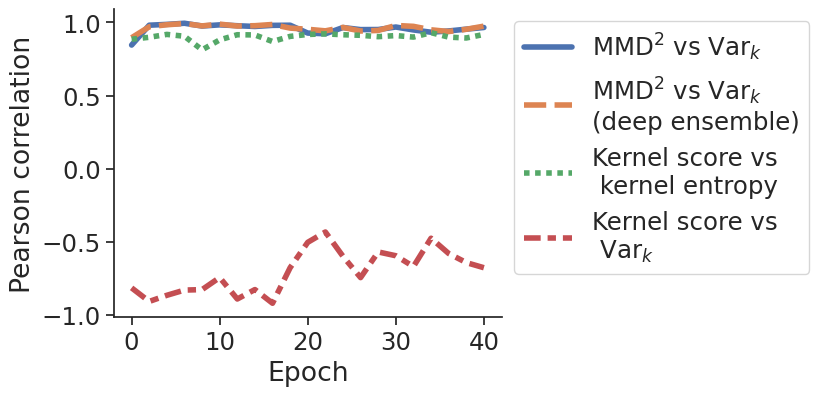

In [56]:
plt.figure(figsize=(5, 4))
sns.set(font_scale=1.6)
sns.set_style('ticks')
line_size = 4
plot = sns.lineplot(corr_df, linewidth=line_size)
plot.set(ylabel='Pearson correlation', xlabel='Epoch')
sns.despine()
leg = plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
for line in leg.get_lines():
    line.set_linewidth(4)
plot.figure.savefig('plots/corr_default_combo_{}.pdf'.format(kernel_str), bbox_inches='tight')
plot.figure.show();